In [1]:
!nvidia-smi

Mon Feb 19 10:50:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   40C    P8              21W / 215W |    585MiB /  8192MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import traceback
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

data_dir = '../data/physionet/fold4/'

cuda


In [6]:
sr = 16000

x_train = np.load(f'{data_dir}heartsound.audio16k.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}heartsound.audio16k.test.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}heartsound.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}heartsound.labels_binary.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}heartsound.labels_binary.test.npy', allow_pickle=True)

In [7]:
from einops import rearrange, reduce, repeat
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = torch.tensor(x_train)[:, None ,:]
    y_train = torch.tensor(y_train)
    x_test = torch.tensor(x_test)[:, None, :]
    y_test = torch.tensor(y_test)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=False, 
                              batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, 
                             batch_size=batch_size, drop_last=True)
    return train_loader, test_loader

In [8]:
batch_size = 32
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)
labels = classnames

In [9]:
from IConNet.nn.model import M12
from omegaconf import OmegaConf as ocf
from IConNet.visualizer import visualize_model

model_config_path = 'config/model/m15_physio16k.yaml'
model_config = ocf.load(model_config_path)
print(ocf.to_yaml(model_config))
model = M12(config=model_config,
           n_input=1, n_output=2)
print(model)

print(f'total parameters: {visualize_model.count_parameters(model)}')
print(f'FE parameters: {visualize_model.count_parameters(model.fe_blocks)}')

name: M15_physio16k
description: FirConv sequential for physio16k
fe:
  n_block: 2
  n_channel:
  - 64
  - 64
  kernel_size:
  - 511
  - 127
  stride:
  - 8
  - 2
  window_k:
  - 2
  - 9
  residual_connection_type: concat
  pooling: false
  filter_type: firwin
  conv_mode: fftconv
  norm_type: LocalResponseNorm
seq:
  n_block: 1
  n_channel: 32
  pooling: max
  use_context: true
  bidirectional: false
cls:
  n_block: 2
  n_hidden_dim:
  - 256
  - 256
  norm_type: LayerNorm

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
 

In [10]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [11]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    # print(f'Mem before training: {torch.cuda.memory_allocated()}')
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [12]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                                                                        | 0.004123711340206186/10 [00:00<25:29, 153.02s/it]

Train Epoch: 1 [0/11481 (0%)]	Loss: 0.526874
Mem before-during-after: 615424 2687603200 32988672


  1%|█                                                                                                                        | 0.08453608247422686/10 [00:10<22:01, 133.31s/it]

Train Epoch: 1 [1280/11481 (11%)]	Loss: 0.308445
Mem before-during-after: 32841216 2690632192 32955904


  2%|██                                                                                                                       | 0.16907216494845365/10 [00:21<19:44, 120.46s/it]

Train Epoch: 1 [2560/11481 (22%)]	Loss: 0.594562
Mem before-during-after: 32841216 2690632192 32955904


  3%|███                                                                                                                       | 0.2515463917525771/10 [00:31<19:31, 120.14s/it]

Train Epoch: 1 [3840/11481 (34%)]	Loss: 0.091057
Mem before-during-after: 32841216 2690632192 32955904


  3%|████                                                                                                                      | 0.3340206185567005/10 [00:41<18:59, 117.84s/it]

Train Epoch: 1 [5120/11481 (45%)]	Loss: 0.568639
Mem before-during-after: 32841216 2690632192 32955904


  4%|█████                                                                                                                    | 0.41649484536082393/10 [00:51<19:06, 119.63s/it]

Train Epoch: 1 [6400/11481 (56%)]	Loss: 0.376203
Mem before-during-after: 32841216 2690632192 32955904


  5%|██████                                                                                                                   | 0.49896907216494735/10 [01:01<20:02, 126.55s/it]

Train Epoch: 1 [7680/11481 (67%)]	Loss: 0.519957
Mem before-during-after: 32841216 2690632192 32955904


  6%|███████                                                                                                                   | 0.5814432989690708/10 [01:12<18:26, 117.49s/it]

Train Epoch: 1 [8960/11481 (78%)]	Loss: 0.307514
Mem before-during-after: 32841216 2690632192 32955904


  7%|████████                                                                                                                  | 0.6639175257731942/10 [01:22<19:22, 124.52s/it]

Train Epoch: 1 [10240/11481 (89%)]	Loss: 0.767647
Mem before-during-after: 32841216 2690632192 32955904


 10%|████████████▎                                                                                                              | 0.9999999999999971/10 [01:55<13:12, 88.11s/it]


Test Epoch: 1	Accuracy: 3093/4064 (76%)



 10%|████████████▎                                                                                                              | 1.0041237113402033/10 [01:55<14:23, 95.94s/it]

Train Epoch: 2 [0/11481 (0%)]	Loss: 0.292941
Mem before-during-after: 32932352 2697996288 33005056


 11%|█████████████▎                                                                                                            | 1.0865979381443267/10 [02:05<18:01, 121.32s/it]

Train Epoch: 2 [1280/11481 (11%)]	Loss: 0.243186
Mem before-during-after: 32841216 2690664960 32939520


 12%|██████████████▎                                                                                                            | 1.167010309278347/10 [02:15<19:55, 135.32s/it]

Train Epoch: 2 [2560/11481 (22%)]	Loss: 0.549546
Mem before-during-after: 32841216 2690664960 32939520


 13%|███████████████▎                                                                                                          | 1.2515463917525735/10 [02:26<17:18, 118.65s/it]

Train Epoch: 2 [3840/11481 (34%)]	Loss: 0.094257
Mem before-during-after: 32841216 2690664960 32939520


 13%|████████████████▍                                                                                                          | 1.334020618556697/10 [02:36<17:09, 118.81s/it]

Train Epoch: 2 [5120/11481 (45%)]	Loss: 0.730038
Mem before-during-after: 32841216 2690664960 32939520


 14%|█████████████████▎                                                                                                        | 1.4164948453608204/10 [02:46<17:05, 119.43s/it]

Train Epoch: 2 [6400/11481 (56%)]	Loss: 0.411973
Mem before-during-after: 32841216 2690664960 32939520


 15%|██████████████████▎                                                                                                       | 1.4989690721649438/10 [02:56<17:03, 120.34s/it]

Train Epoch: 2 [7680/11481 (67%)]	Loss: 0.579666
Mem before-during-after: 32841216 2690664960 32939520


 16%|███████████████████▎                                                                                                      | 1.5814432989690672/10 [03:06<16:46, 119.53s/it]

Train Epoch: 2 [8960/11481 (78%)]	Loss: 0.304485
Mem before-during-after: 32841216 2690664960 32939520


 17%|████████████████████▎                                                                                                     | 1.6618556701030875/10 [03:16<18:15, 131.43s/it]

Train Epoch: 2 [10240/11481 (89%)]	Loss: 0.493588
Mem before-during-after: 32841216 2690664960 32939520


 20%|████████████████████████▌                                                                                                  | 1.9999999999999936/10 [03:49<11:38, 87.26s/it]


Test Epoch: 2	Accuracy: 3157/4064 (77%)



 20%|█████████████████████████▎                                                                                                    | 2.0041237113402/10 [03:49<13:03, 97.97s/it]

Train Epoch: 3 [0/11481 (0%)]	Loss: 0.172212
Mem before-during-after: 33063424 2698127360 33037824


 21%|█████████████████████████▍                                                                                                | 2.0865979381443234/10 [03:59<15:33, 118.02s/it]

Train Epoch: 3 [1280/11481 (11%)]	Loss: 0.305194
Mem before-during-after: 33127936 2692016128 32955904


 22%|██████████████████████████▋                                                                                                | 2.169072164948447/10 [04:09<15:37, 119.70s/it]

Train Epoch: 3 [2560/11481 (22%)]	Loss: 0.495768
Mem before-during-after: 33127936 2692016128 32955904


 23%|███████████████████████████▉                                                                                                | 2.25154639175257/10 [04:19<15:21, 118.97s/it]

Train Epoch: 3 [3840/11481 (34%)]	Loss: 0.046089
Mem before-during-after: 33127936 2692016128 32955904


 23%|████████████████████████████▍                                                                                             | 2.3340206185566936/10 [04:29<15:19, 119.92s/it]

Train Epoch: 3 [5120/11481 (45%)]	Loss: 0.652405
Mem before-during-after: 33127936 2692016128 32955904


 24%|█████████████████████████████▋                                                                                             | 2.416494845360817/10 [04:39<15:10, 120.10s/it]

Train Epoch: 3 [6400/11481 (56%)]	Loss: 0.324904
Mem before-during-after: 33127936 2692016128 32955904


 25%|██████████████████████████████▍                                                                                           | 2.4989690721649405/10 [04:49<14:57, 119.70s/it]

Train Epoch: 3 [7680/11481 (67%)]	Loss: 0.690438
Mem before-during-after: 33127936 2692016128 32955904


 26%|███████████████████████████████▊                                                                                           | 2.581443298969064/10 [04:59<14:58, 121.12s/it]

Train Epoch: 3 [8960/11481 (78%)]	Loss: 0.329531
Mem before-during-after: 33127936 2692016128 32955904


 27%|████████████████████████████████▍                                                                                         | 2.6639175257731873/10 [05:09<14:52, 121.64s/it]

Train Epoch: 3 [10240/11481 (89%)]	Loss: 1.003770
Mem before-during-after: 33127936 2692016128 32955904


 30%|████████████████████████████████████▉                                                                                      | 2.9999999999999902/10 [05:42<10:34, 90.64s/it]


Test Epoch: 3	Accuracy: 3075/4064 (75%)



 30%|████████████████████████████████████▉                                                                                      | 3.0041237113401964/10 [05:42<11:18, 96.98s/it]

Train Epoch: 4 [0/11481 (0%)]	Loss: 0.077526
Mem before-during-after: 33128960 2698398208 33210368


 31%|█████████████████████████████████████▋                                                                                    | 3.0845360824742167/10 [05:52<15:17, 132.74s/it]

Train Epoch: 4 [1280/11481 (11%)]	Loss: 0.135329
Mem before-during-after: 33111552 2691942912 33242624


 32%|███████████████████████████████████████▎                                                                                    | 3.16701030927834/10 [06:02<15:35, 136.93s/it]

Train Epoch: 4 [2560/11481 (22%)]	Loss: 0.512576
Mem before-during-after: 33111552 2691942912 33242624


 32%|███████████████████████████████████████▋                                                                                  | 3.2494845360824636/10 [06:12<14:46, 131.27s/it]

Train Epoch: 4 [3840/11481 (34%)]	Loss: 0.037753
Mem before-during-after: 33111552 2691942912 33242624


 33%|████████████████████████████████████████▉                                                                                  | 3.331958762886587/10 [06:22<14:25, 129.85s/it]

Train Epoch: 4 [5120/11481 (45%)]	Loss: 0.699120
Mem before-during-after: 33111552 2691942912 33242624


 34%|█████████████████████████████████████████▋                                                                                | 3.4164948453608135/10 [06:33<13:25, 122.37s/it]

Train Epoch: 4 [6400/11481 (56%)]	Loss: 0.283997
Mem before-during-after: 33111552 2691942912 33242624


 35%|███████████████████████████████████████████                                                                                | 3.498969072164937/10 [06:43<12:48, 118.29s/it]

Train Epoch: 4 [7680/11481 (67%)]	Loss: 0.536022
Mem before-during-after: 33111552 2691942912 33242624


 36%|███████████████████████████████████████████▋                                                                              | 3.5814432989690603/10 [06:53<12:47, 119.50s/it]

Train Epoch: 4 [8960/11481 (78%)]	Loss: 0.303979
Mem before-during-after: 33111552 2691942912 33242624


 37%|████████████████████████████████████████████▋                                                                             | 3.6618556701030807/10 [07:03<13:52, 131.32s/it]

Train Epoch: 4 [10240/11481 (89%)]	Loss: 0.498467
Mem before-during-after: 33111552 2691942912 33242624


 40%|█████████████████████████████████████████████████▏                                                                         | 3.9999999999999867/10 [07:36<08:38, 86.34s/it]


Test Epoch: 4	Accuracy: 3121/4064 (76%)



 40%|█████████████████████████████████████████████████▋                                                                          | 4.004123711340193/10 [07:36<09:34, 95.80s/it]

Train Epoch: 5 [0/11481 (0%)]	Loss: 0.076293
Mem before-during-after: 33128960 2698398208 33210368


 41%|██████████████████████████████████████████████████▎                                                                        | 4.086597938144316/10 [07:46<11:40, 118.49s/it]

Train Epoch: 5 [1280/11481 (11%)]	Loss: 0.132142
Mem before-during-after: 33111552 2691942912 33242624


 42%|███████████████████████████████████████████████████▋                                                                        | 4.16907216494844/10 [07:56<11:24, 117.35s/it]

Train Epoch: 5 [2560/11481 (22%)]	Loss: 0.441440
Mem before-during-after: 33111552 2691942912 33242624


 43%|████████████████████████████████████████████████████▎                                                                      | 4.251546391752563/10 [08:06<11:27, 119.60s/it]

Train Epoch: 5 [3840/11481 (34%)]	Loss: 0.088129
Mem before-during-after: 33111552 2691942912 33242624


 43%|████████████████████████████████████████████████████▉                                                                     | 4.3340206185566865/10 [08:16<11:08, 118.05s/it]

Train Epoch: 5 [5120/11481 (45%)]	Loss: 0.876133
Mem before-during-after: 33111552 2691942912 33242624


 44%|██████████████████████████████████████████████████████▊                                                                     | 4.41649484536081/10 [08:26<11:06, 119.33s/it]

Train Epoch: 5 [6400/11481 (56%)]	Loss: 0.161961
Mem before-during-after: 33111552 2691942912 33242624


 45%|███████████████████████████████████████████████████████▎                                                                   | 4.498969072164933/10 [08:36<10:56, 119.31s/it]

Train Epoch: 5 [7680/11481 (67%)]	Loss: 0.596893
Mem before-during-after: 33111552 2691942912 33242624


 46%|████████████████████████████████████████████████████████▎                                                                  | 4.581443298969057/10 [08:46<10:43, 118.74s/it]

Train Epoch: 5 [8960/11481 (78%)]	Loss: 0.277523
Mem before-during-after: 33111552 2691942912 33242624


 47%|█████████████████████████████████████████████████████████▊                                                                  | 4.66391752577318/10 [08:56<10:30, 118.08s/it]

Train Epoch: 5 [10240/11481 (89%)]	Loss: 0.503740
Mem before-during-after: 33111552 2691942912 33242624


 50%|█████████████████████████████████████████████████████████████▉                                                              | 4.999999999999983/10 [09:28<07:42, 92.53s/it]


Test Epoch: 5	Accuracy: 3130/4064 (76%)



 50%|█████████████████████████████████████████████████████████████▌                                                             | 5.002061855670086/10 [09:28<08:34, 102.89s/it]

Train Epoch: 6 [0/11481 (0%)]	Loss: 0.069838
Mem before-during-after: 33128960 2698398208 33210368


 51%|██████████████████████████████████████████████████████████████▌                                                            | 5.086597938144313/10 [09:39<09:52, 120.56s/it]

Train Epoch: 6 [1280/11481 (11%)]	Loss: 0.045530
Mem before-during-after: 33111552 2691942912 33242624


 52%|███████████████████████████████████████████████████████████████▌                                                           | 5.169072164948436/10 [09:49<09:43, 120.80s/it]

Train Epoch: 6 [2560/11481 (22%)]	Loss: 0.396588
Mem before-during-after: 33111552 2691942912 33242624


 53%|████████████████████████████████████████████████████████████████                                                          | 5.2515463917525596/10 [09:59<09:16, 117.18s/it]

Train Epoch: 6 [3840/11481 (34%)]	Loss: 0.036525
Mem before-during-after: 33111552 2691942912 33242624


 53%|█████████████████████████████████████████████████████████████████▌                                                         | 5.334020618556683/10 [10:09<09:12, 118.46s/it]

Train Epoch: 6 [5120/11481 (45%)]	Loss: 0.673033
Mem before-during-after: 33111552 2691942912 33242624


 54%|██████████████████████████████████████████████████████████████████▌                                                        | 5.416494845360806/10 [10:19<09:03, 118.49s/it]

Train Epoch: 6 [6400/11481 (56%)]	Loss: 0.186675
Mem before-during-after: 33111552 2691942912 33242624


 55%|████████████████████████████████████████████████████████████████████▏                                                       | 5.49896907216493/10 [10:29<08:54, 118.78s/it]

Train Epoch: 6 [7680/11481 (67%)]	Loss: 0.546613
Mem before-during-after: 33111552 2691942912 33242624


 56%|████████████████████████████████████████████████████████████████████▋                                                      | 5.581443298969053/10 [10:39<08:46, 119.22s/it]

Train Epoch: 6 [8960/11481 (78%)]	Loss: 0.236598
Mem before-during-after: 33111552 2691942912 33242624


 57%|█████████████████████████████████████████████████████████████████████▋                                                     | 5.663917525773177/10 [10:49<08:30, 117.76s/it]

Train Epoch: 6 [10240/11481 (89%)]	Loss: 0.426830
Mem before-during-after: 33111552 2691942912 33242624


 60%|██████████████████████████████████████████████████████████████████████████▉                                                  | 5.99999999999998/10 [11:21<05:47, 86.85s/it]


Test Epoch: 6	Accuracy: 3072/4064 (75%)



 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 6.004123711340186/10 [11:21<06:24, 96.23s/it]

Train Epoch: 7 [0/11481 (0%)]	Loss: 0.119153
Mem before-during-after: 33128960 2698398208 33210368


 61%|██████████████████████████████████████████████████████████████████████████▊                                                | 6.086597938144309/10 [11:31<07:42, 118.08s/it]

Train Epoch: 7 [1280/11481 (11%)]	Loss: 0.154901
Mem before-during-after: 33111552 2691942912 33242624


 62%|███████████████████████████████████████████████████████████████████████████▉                                               | 6.169072164948433/10 [11:41<07:35, 118.89s/it]

Train Epoch: 7 [2560/11481 (22%)]	Loss: 0.366746
Mem before-during-after: 33111552 2691942912 33242624


 63%|████████████████████████████████████████████████████████████████████████████▉                                              | 6.251546391752556/10 [11:51<07:23, 118.38s/it]

Train Epoch: 7 [3840/11481 (34%)]	Loss: 0.045764
Mem before-during-after: 33111552 2691942912 33242624


 63%|█████████████████████████████████████████████████████████████████████████████▉                                             | 6.334020618556679/10 [12:01<07:11, 117.79s/it]

Train Epoch: 7 [5120/11481 (45%)]	Loss: 0.637364
Mem before-during-after: 33111552 2691942912 33242624


 64%|██████████████████████████████████████████████████████████████████████████████▉                                            | 6.416494845360803/10 [12:11<07:06, 119.03s/it]

Train Epoch: 7 [6400/11481 (56%)]	Loss: 0.210323
Mem before-during-after: 33111552 2691942912 33242624


 65%|███████████████████████████████████████████████████████████████████████████████▉                                           | 6.498969072164926/10 [12:21<06:53, 118.01s/it]

Train Epoch: 7 [7680/11481 (67%)]	Loss: 0.368093
Mem before-during-after: 33111552 2691942912 33242624


 66%|█████████████████████████████████████████████████████████████████████████████████▌                                          | 6.58144329896905/10 [12:31<06:46, 118.96s/it]

Train Epoch: 7 [8960/11481 (78%)]	Loss: 0.188749
Mem before-during-after: 33111552 2691942912 33242624


 67%|█████████████████████████████████████████████████████████████████████████████████▉                                         | 6.663917525773173/10 [12:41<06:32, 117.67s/it]

Train Epoch: 7 [10240/11481 (89%)]	Loss: 0.472598
Mem before-during-after: 33111552 2691942912 33242624


 70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 6.999999999999976/10 [13:13<04:20, 86.79s/it]


Test Epoch: 7	Accuracy: 3209/4064 (78%)



 70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 7.004123711340182/10 [13:13<04:47, 95.88s/it]

Train Epoch: 8 [0/11481 (0%)]	Loss: 0.049716
Mem before-during-after: 33128960 2698398208 33210368


 71%|███████████████████████████████████████████████████████████████████████████████████████▏                                   | 7.086597938144306/10 [13:23<05:44, 118.36s/it]

Train Epoch: 8 [1280/11481 (11%)]	Loss: 0.100981
Mem before-during-after: 33111552 2691942912 33242624


 72%|████████████████████████████████████████████████████████████████████████████████████████▏                                  | 7.169072164948429/10 [13:33<05:33, 117.90s/it]

Train Epoch: 8 [2560/11481 (22%)]	Loss: 0.439672
Mem before-during-after: 33111552 2691942912 33242624


 73%|████████████████████████████████████████████████████████████████████████████████████████▍                                 | 7.2515463917525524/10 [13:43<05:33, 121.31s/it]

Train Epoch: 8 [3840/11481 (34%)]	Loss: 0.028997
Mem before-during-after: 33111552 2691942912 33242624


 73%|██████████████████████████████████████████████████████████████████████████████████████████▏                                | 7.334020618556676/10 [13:53<05:18, 119.65s/it]

Train Epoch: 8 [5120/11481 (45%)]	Loss: 0.683148
Mem before-during-after: 33111552 2691942912 33242624


 74%|███████████████████████████████████████████████████████████████████████████████████████████▏                               | 7.414432989690696/10 [14:03<05:48, 134.92s/it]

Train Epoch: 8 [6400/11481 (56%)]	Loss: 0.183493
Mem before-during-after: 33111552 2691942912 33242624


 75%|████████████████████████████████████████████████████████████████████████████████████████████▏                              | 7.498969072164923/10 [14:14<05:01, 120.37s/it]

Train Epoch: 8 [7680/11481 (67%)]	Loss: 0.307557
Mem before-during-after: 33111552 2691942912 33242624


 76%|█████████████████████████████████████████████████████████████████████████████████████████████▎                             | 7.581443298969046/10 [14:24<04:45, 118.23s/it]

Train Epoch: 8 [8960/11481 (78%)]	Loss: 0.150287
Mem before-during-after: 33111552 2691942912 33242624


 77%|█████████████████████████████████████████████████████████████████████████████████████████████▍                            | 7.6639175257731695/10 [14:34<04:36, 118.54s/it]

Train Epoch: 8 [10240/11481 (89%)]	Loss: 0.640615
Mem before-during-after: 33111552 2691942912 33242624


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 7.9999999999999725/10 [15:06<02:56, 88.10s/it]


Test Epoch: 8	Accuracy: 3435/4064 (84%)



 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8.002061855670076/10 [15:06<03:19, 99.74s/it]

Train Epoch: 9 [0/11481 (0%)]	Loss: 0.006663
Mem before-during-after: 33128960 2698398208 33210368


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8.086597938144303/10 [15:16<03:45, 117.80s/it]

Train Epoch: 9 [1280/11481 (11%)]	Loss: 0.010707
Mem before-during-after: 33111552 2691942912 33242624


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 8.169072164948426/10 [15:26<03:39, 119.80s/it]

Train Epoch: 9 [2560/11481 (22%)]	Loss: 0.619826
Mem before-during-after: 33111552 2691942912 33242624


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8.25154639175255/10 [15:36<03:32, 121.62s/it]

Train Epoch: 9 [3840/11481 (34%)]	Loss: 0.037593
Mem before-during-after: 33111552 2691942912 33242624


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 8.334020618556673/10 [15:46<03:16, 118.04s/it]

Train Epoch: 9 [5120/11481 (45%)]	Loss: 0.974524
Mem before-during-after: 33111552 2691942912 33242624


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 8.416494845360797/10 [15:56<03:06, 117.64s/it]

Train Epoch: 9 [6400/11481 (56%)]	Loss: 0.330657
Mem before-during-after: 33111552 2691942912 33242624


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 8.49896907216492/10 [16:06<02:58, 118.93s/it]

Train Epoch: 9 [7680/11481 (67%)]	Loss: 0.266242
Mem before-during-after: 33111552 2691942912 33242624


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 8.581443298969043/10 [16:16<02:52, 121.70s/it]

Train Epoch: 9 [8960/11481 (78%)]	Loss: 0.164318
Mem before-during-after: 33111552 2691942912 33242624


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 8.663917525773167/10 [16:26<02:41, 121.22s/it]

Train Epoch: 9 [10240/11481 (89%)]	Loss: 0.793323
Mem before-during-after: 33111552 2691942912 33242624


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 8.99999999999997/10 [16:58<01:27, 87.45s/it]


Test Epoch: 9	Accuracy: 3368/4064 (82%)



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9.004123711340176/10 [16:59<01:36, 97.01s/it]

Train Epoch: 10 [0/11481 (0%)]	Loss: 0.004498
Mem before-during-after: 33128960 2698398208 33210368


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9.0865979381443/10 [17:09<01:47, 118.08s/it]

Train Epoch: 10 [1280/11481 (11%)]	Loss: 0.007647
Mem before-during-after: 33111552 2691942912 33242624


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 9.169072164948423/10 [17:19<01:38, 118.91s/it]

Train Epoch: 10 [2560/11481 (22%)]	Loss: 0.564850
Mem before-during-after: 33111552 2691942912 33242624


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9.251546391752546/10 [17:29<01:29, 118.97s/it]

Train Epoch: 10 [3840/11481 (34%)]	Loss: 0.021511
Mem before-during-after: 33111552 2691942912 33242624


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 9.33402061855667/10 [17:39<01:20, 121.25s/it]

Train Epoch: 10 [5120/11481 (45%)]	Loss: 0.881679
Mem before-during-after: 33111552 2691942912 33242624


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 9.416494845360793/10 [17:49<01:09, 119.10s/it]

Train Epoch: 10 [6400/11481 (56%)]	Loss: 0.240774
Mem before-during-after: 33111552 2691942912 33242624


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9.498969072164916/10 [17:58<00:58, 117.59s/it]

Train Epoch: 10 [7680/11481 (67%)]	Loss: 0.225167
Mem before-during-after: 33111552 2691942912 33242624


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9.58144329896904/10 [18:08<00:49, 119.33s/it]

Train Epoch: 10 [8960/11481 (78%)]	Loss: 0.144491
Mem before-during-after: 33111552 2691942912 33242624


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9.663917525773163/10 [18:18<00:39, 118.92s/it]

Train Epoch: 10 [10240/11481 (89%)]	Loss: 0.469034
Mem before-during-after: 33111552 2691942912 33242624


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9.999999999999966/10 [18:51<00:00, 113.11s/it]


Test Epoch: 10	Accuracy: 3453/4064 (84%)



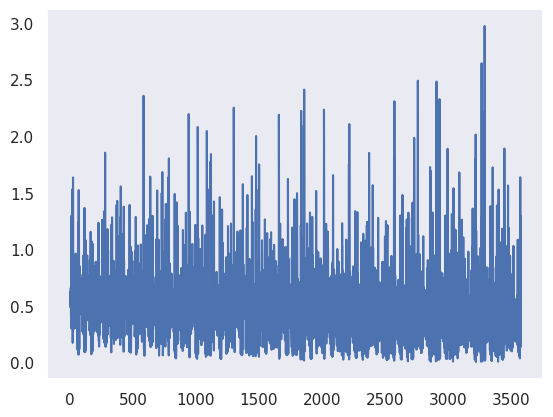

In [13]:
plt.plot(train_losses)

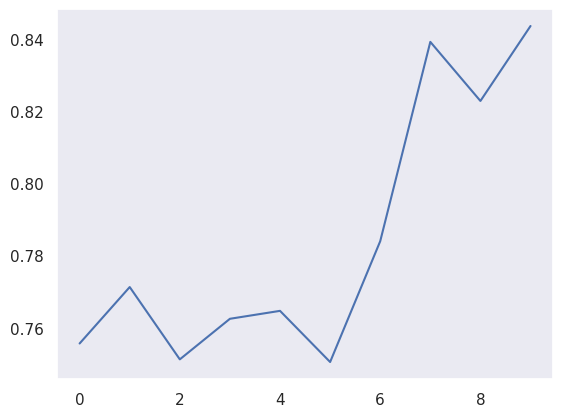

In [14]:
plt.plot(test_accuracy)

In [15]:
model_path = '../physio16k_fold4_m12_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [16]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from torchmetrics.wrappers import ClasswiseWrapper
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [17]:
metrics, confusion_matrix = report_metrics(model)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 3451/4064 (0.8492)
{'acc_detail': tensor([0.5630, 0.9386], device='cuda:0'),
 'acc_unweighted': tensor(0.7508, device='cuda:0'),
 'acc_weighted': tensor(0.8492, device='cuda:0'),
 'f1s': tensor(0.7723, device='cuda:0'),
 'f1s_detail': tensor([0.6400, 0.9046], device='cuda:0'),
 'precision_detail': tensor([0.7415, 0.8729], device='cuda:0'),
 'recall_detail': tensor([0.5630, 0.9386], device='cuda:0'),
 'rocauc': tensor([0.8599, 0.8599], device='cuda:0'),
 'uar': tensor(0.7508, device='cuda:0'),
 'wap': tensor(0.8416, device='cuda:0')}


tensor([[ 545,  423],
        [ 190, 2906]], device='cuda:0')

In [18]:
layer = model.fe_blocks.blocks[0].block.layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0075],
        [0.0162],
        [0.0264],
        [0.0384],
        [0.0524],
        [0.0688],
        [0.0880],
        [0.1105],
        [0.1368],
        [0.1676],
        [0.2036],
        [0.2458],
        [0.2952],
        [0.3531],
        [0.4208],
        [0.0000],
        [0.0111],
        [0.0235],
        [0.0375],
        [0.0534],
        [0.0712],
        [0.0912],
        [0.1138],
        [0.1392],
        [0.1679],
        [0.2002],
        [0.2365],
        [0.2775],
        [0.3236],
        [0.3756],
        [0.4341],
        [0.0000],
        [0.0154],
        [0.0322],
        [0.0504],
        [0.0702],
        [0.0918],
        [0.1153],
        [0.1409],
        [0.1687],
        [0.1989],
        [0.2319],
        [0.2677],
        [0.3067],
        [0.3491],
        [0.3952],
        [0.4454],
        [0.0000],
        [0.0200],
        [0.0411],
        [0.0634],
        [0.0869],
       

In [19]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [-4.0188e-16],
        [ 2.4310e-16],
        [-2.5688e-17],
        [ 5.3191e-17],
        [ 3.2101e-16],
        [ 4.2004e-15],
        [ 7.8720e-15],
        [ 8.6450e-15],
        [ 1.9643e-15],
        [ 1.1881e-16],
        [ 1.1400e-14],
        [-1.1187e-15],
        [-1.3715e-15],
        [ 7.5294e-15],
        [-7.5239e-14],
        [ 0.0000e+00],
        [-2.3757e-14],
        [ 2.5520e-14],
        [ 1.5488e-16],
        [-6.2595e-16],
        [ 1.5199e-16],
        [ 5.9959e-17],
        [ 7.0432e-17],
        [ 5.1943e-16],
        [-2.7558e-16],
        [-7.8720e-16],
        [-2.6806e-15],
        [-1.3530e-15],
        [ 1.8271e-16],
        [ 1.1390e-14],
        [ 3.4382e-16],
        [ 0.0000e+00],
        [-9.6012e-16],
        [ 1.6559e-16],
        [ 3.9079e-16],
        [ 5.6215e-15],
        [-6.9218e-17],
        [ 1.5143e-13],
        [-1.6808e-13],
        [ 4.9177e-17],
        [-8.8353e-17],
        [-9.1840e-17],
        [-3

[None, None, None]

Time domain: Filters' shapes vary by frequency bins


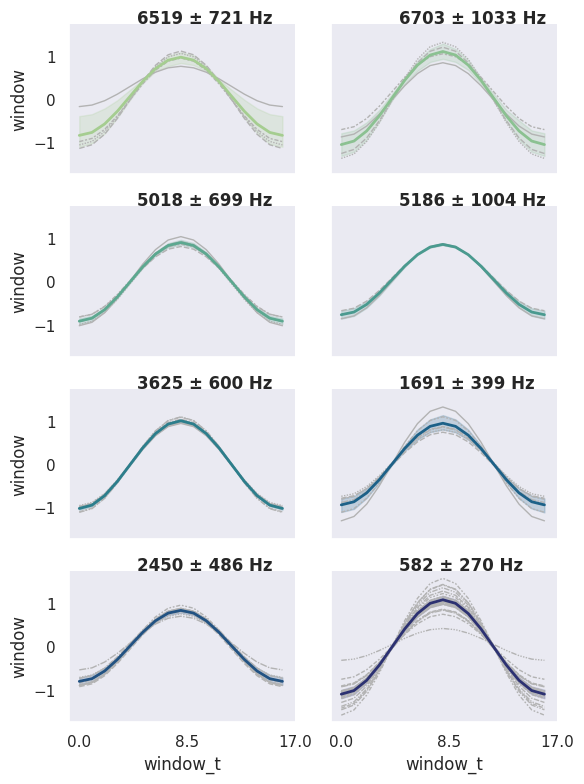

In [20]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


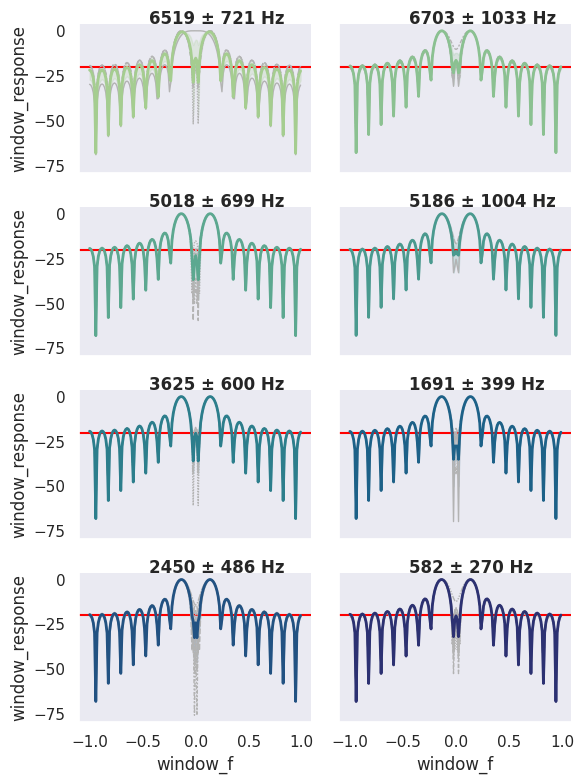

In [22]:
filtviz.visualize_filters(filter_domain='freq')

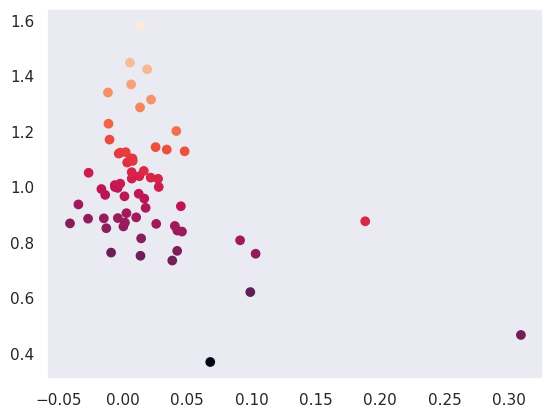

In [23]:
filtviz.visualize_window_params()

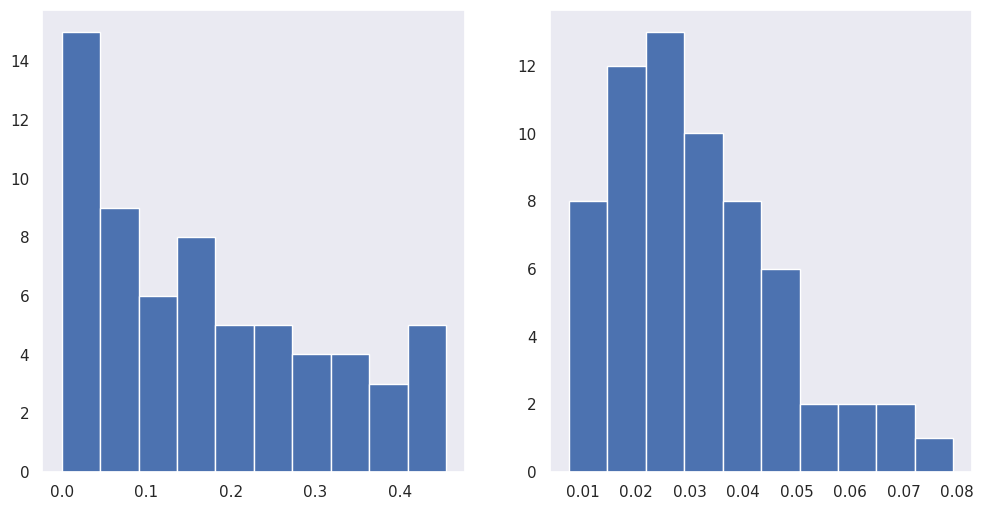

In [30]:
filtviz.visualize_bands()

In [25]:
layer2 = model.fe_blocks.blocks[1].block.layer
visualize_model.print_parameters(layer2)

('lowcut_bands', Parameter containing:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0075, 0.0075, 0.0075,  ..., 0.0075, 0.0075, 0.0075],
        [0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
        ...,
        [0.3697, 0.3697, 0.3697,  ..., 0.3697, 0.3697, 0.3697],
        [0.4108, 0.4108, 0.4108,  ..., 0.4108, 0.4108, 0.4108],
        [0.4541, 0.4541, 0.4541,  ..., 0.4541, 0.4541, 0.4541]],
       device='cuda:0', requires_grad=True))
('bandwidths', Parameter containing:
tensor([[0.0075, 0.0075, 0.0075,  ..., 0.0075, 0.0075, 0.0075],
        [0.0087, 0.0087, 0.0087,  ..., 0.0087, 0.0087, 0.0087],
        [0.0102, 0.0102, 0.0102,  ..., 0.0102, 0.0102, 0.0102],
        ...,
        [0.0410, 0.0410, 0.0410,  ..., 0.0410, 0.0410, 0.0410],
        [0.0434, 0.0434, 0.0434,  ..., 0.0434, 0.0434, 0.0434],
        [0.0459, 0.0459, 0.0459,  ..., 0.0459, 0.0459, 0.0459]],
       device='cuda:0', requires_grad=True))
('window_params', Parameter containing

downsample_factor: 8 => new_sample_rate: 2000
Time domain: Filters' shapes vary by frequency bins


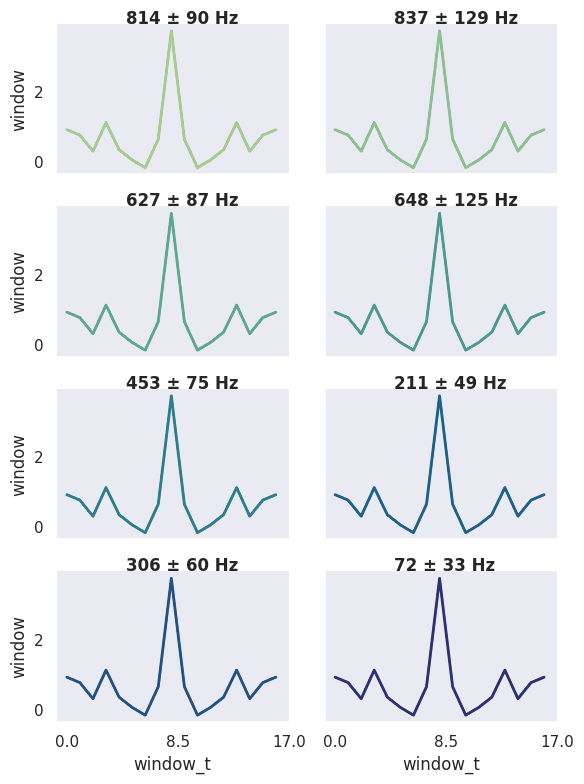

In [26]:
downsample_factor = model.fe_blocks.blocks[0].stride
new_sample_rate = sr // downsample_factor
print(f'downsample_factor: {downsample_factor} => new_sample_rate: {new_sample_rate}')

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = layer2.window_params, 
    window_length = 64,
    sample_rate = new_sample_rate
)
filtviz2.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


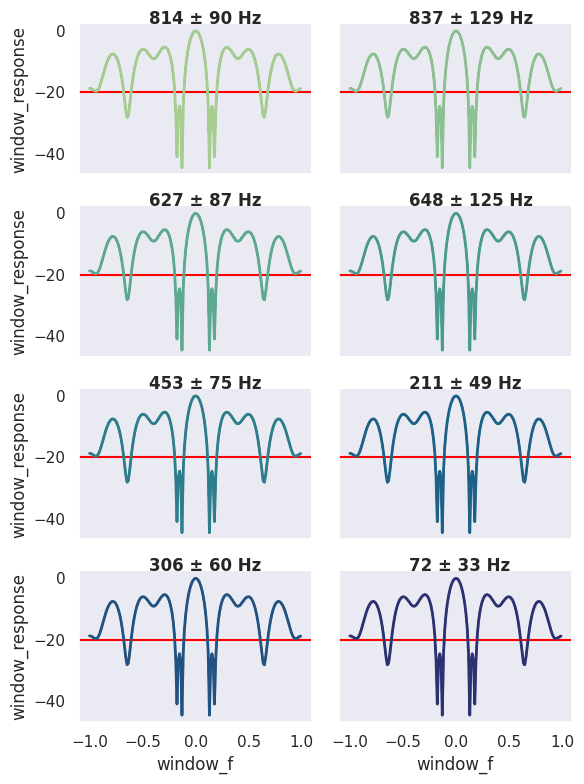

In [27]:
filtviz2.visualize_filters(filter_domain='freq')

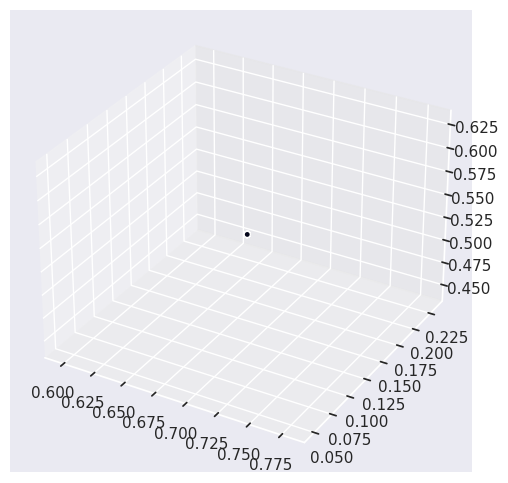

In [28]:
filtviz2.visualize_window_params()

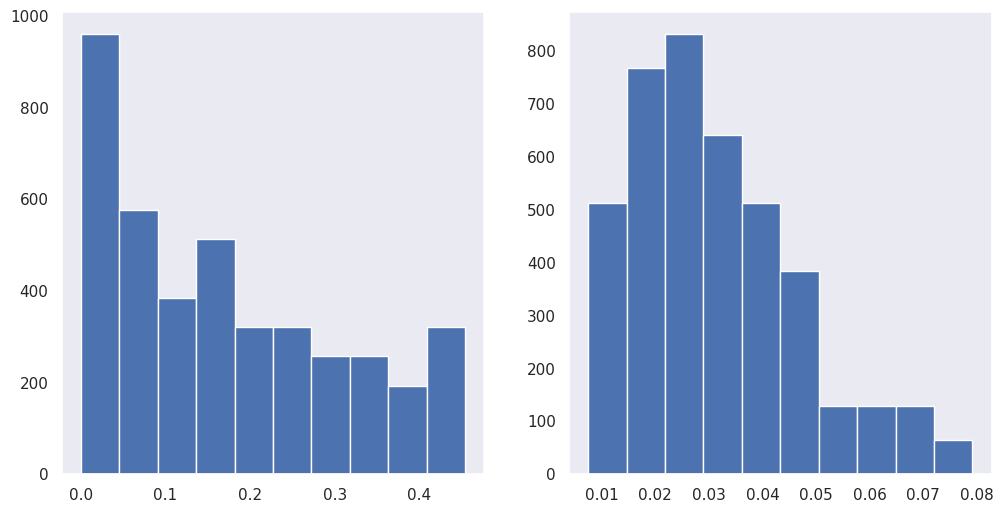

In [29]:
filtviz2.visualize_bands()

In [31]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)

log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                                                                      | 0.002061855670103093/50 [00:00<4:12:37, 303.17s/it]

Train Epoch: 11 [0/11481 (0%)]	Loss: 0.004031
Mem before-during-after: 31753728 2697219584 32961024


  0%|▏                                                                                                                      | 0.08453608247422686/50 [00:11<1:58:46, 142.77s/it]

Train Epoch: 11 [1280/11481 (11%)]	Loss: 0.026679
Mem before-during-after: 33264128 2691677696 33264128


  0%|▍                                                                                                                      | 0.16701030927835056/50 [00:22<1:58:00, 142.09s/it]

Train Epoch: 11 [2560/11481 (22%)]	Loss: 0.755406
Mem before-during-after: 33264128 2691677696 33264128


  0%|▌                                                                                                                      | 0.24948453608247398/50 [00:33<1:58:04, 142.40s/it]

Train Epoch: 11 [3840/11481 (34%)]	Loss: 0.071997
Mem before-during-after: 33264128 2691677696 33264128


  1%|▊                                                                                                                       | 0.3340206185567005/50 [00:44<1:48:38, 131.25s/it]

Train Epoch: 11 [5120/11481 (45%)]	Loss: 0.937765
Mem before-during-after: 33264128 2691677696 33264128


  1%|▉                                                                                                                      | 0.41443298969072084/50 [00:55<2:00:02, 145.25s/it]

Train Epoch: 11 [6400/11481 (56%)]	Loss: 0.223895
Mem before-during-after: 33264128 2691677696 33264128


  1%|█▏                                                                                                                     | 0.49690721649484426/50 [01:06<1:58:18, 143.39s/it]

Train Epoch: 11 [7680/11481 (67%)]	Loss: 0.170615
Mem before-during-after: 33264128 2691677696 33264128


  1%|█▍                                                                                                                      | 0.5793814432989677/50 [01:17<1:59:50, 145.50s/it]

Train Epoch: 11 [8960/11481 (78%)]	Loss: 0.118334
Mem before-during-after: 33264128 2691677696 33264128


  1%|█▌                                                                                                                      | 0.6618556701030911/50 [01:28<1:57:54, 143.39s/it]

Train Epoch: 11 [10240/11481 (89%)]	Loss: 0.229128
Mem before-during-after: 33264128 2691677696 33264128


  2%|██▍                                                                                                                     | 0.9999999999999971/50 [02:05<1:35:38, 117.10s/it]


Test Epoch: 11	Accuracy: 3459/4064 (85%)



  2%|██▍                                                                                                                     | 1.0020618556701002/50 [02:05<1:42:43, 125.79s/it]

Train Epoch: 12 [0/11481 (0%)]	Loss: 0.011024
Mem before-during-after: 33003008 2697837568 32961024


  2%|██▌                                                                                                                     | 1.0845360824742236/50 [02:17<1:56:39, 143.10s/it]

Train Epoch: 12 [1280/11481 (11%)]	Loss: 0.008775
Mem before-during-after: 33264128 2690883072 33264128


  2%|██▊                                                                                                                      | 1.167010309278347/50 [02:28<2:00:02, 147.48s/it]

Train Epoch: 12 [2560/11481 (22%)]	Loss: 0.470024
Mem before-during-after: 33264128 2690883072 33264128


  2%|██▉                                                                                                                     | 1.2494845360824705/50 [02:39<2:00:01, 147.72s/it]

Train Epoch: 12 [3840/11481 (34%)]	Loss: 0.016751
Mem before-during-after: 33264128 2690883072 33264128


  3%|███▏                                                                                                                    | 1.3319587628865939/50 [02:50<1:56:06, 143.13s/it]

Train Epoch: 12 [5120/11481 (45%)]	Loss: 0.772735
Mem before-during-after: 33264128 2690883072 33264128


  3%|███▍                                                                                                                    | 1.4144329896907173/50 [03:01<1:56:44, 144.18s/it]

Train Epoch: 12 [6400/11481 (56%)]	Loss: 0.370855
Mem before-during-after: 33264128 2690883072 33264128


  3%|███▌                                                                                                                    | 1.4969072164948407/50 [03:12<1:56:16, 143.85s/it]

Train Epoch: 12 [7680/11481 (67%)]	Loss: 0.180420
Mem before-during-after: 33264128 2690883072 33264128


  3%|███▊                                                                                                                    | 1.5793814432989641/50 [03:23<1:57:04, 145.07s/it]

Train Epoch: 12 [8960/11481 (78%)]	Loss: 0.122351
Mem before-during-after: 33264128 2690883072 33264128


  3%|███▉                                                                                                                    | 1.6618556701030875/50 [03:35<1:57:57, 146.41s/it]

Train Epoch: 12 [10240/11481 (89%)]	Loss: 0.261774
Mem before-during-after: 33264128 2690883072 33264128


  4%|████▊                                                                                                                   | 1.9999999999999936/50 [04:11<1:22:16, 102.83s/it]


Test Epoch: 12	Accuracy: 3431/4064 (84%)



  4%|████▊                                                                                                                    | 2.002061855670097/50 [04:12<1:30:18, 112.89s/it]

Train Epoch: 13 [0/11481 (0%)]	Loss: 0.005023
Mem before-during-after: 33248768 2698116096 32961024


  4%|█████                                                                                                                   | 2.0845360824742203/50 [04:23<1:53:41, 142.36s/it]

Train Epoch: 13 [1280/11481 (11%)]	Loss: 0.010267
Mem before-during-after: 33026560 2690014720 33092096


  4%|█████▏                                                                                                                  | 2.1670103092783437/50 [04:34<1:59:36, 150.02s/it]

Train Epoch: 13 [2560/11481 (22%)]	Loss: 0.440335
Mem before-during-after: 33026560 2690014720 33092096


  4%|█████▍                                                                                                                   | 2.249484536082467/50 [04:45<1:53:53, 143.10s/it]

Train Epoch: 13 [3840/11481 (34%)]	Loss: 0.011890
Mem before-during-after: 33026560 2690014720 33092096


  5%|█████▌                                                                                                                  | 2.3319587628865905/50 [04:56<1:53:15, 142.55s/it]

Train Epoch: 13 [5120/11481 (45%)]	Loss: 0.781356
Mem before-during-after: 33026560 2690014720 33092096


  5%|█████▊                                                                                                                   | 2.414432989690714/50 [05:07<1:53:43, 143.40s/it]

Train Epoch: 13 [6400/11481 (56%)]	Loss: 0.236196
Mem before-during-after: 33026560 2690014720 33092096


  5%|█████▉                                                                                                                  | 2.4969072164948374/50 [05:18<1:52:43, 142.37s/it]

Train Epoch: 13 [7680/11481 (67%)]	Loss: 0.191744
Mem before-during-after: 33026560 2690014720 33092096


  5%|██████▏                                                                                                                  | 2.579381443298961/50 [05:29<1:51:58, 141.69s/it]

Train Epoch: 13 [8960/11481 (78%)]	Loss: 0.114792
Mem before-during-after: 33026560 2690014720 33092096


  5%|██████▍                                                                                                                  | 2.661855670103084/50 [05:40<1:53:32, 143.92s/it]

Train Epoch: 13 [10240/11481 (89%)]	Loss: 0.352203
Mem before-during-after: 33026560 2690014720 33092096


  6%|███████▎                                                                                                                 | 2.9999999999999902/50 [06:16<1:16:58, 98.28s/it]


Test Epoch: 13	Accuracy: 3430/4064 (84%)



  6%|███████▏                                                                                                                | 3.0020618556700933/50 [06:16<1:25:33, 109.23s/it]

Train Epoch: 14 [0/11481 (0%)]	Loss: 0.002714
Mem before-during-after: 33166848 2698017792 32977408


  6%|███████▍                                                                                                                | 3.0845360824742167/50 [06:27<1:51:08, 142.14s/it]

Train Epoch: 14 [1280/11481 (11%)]	Loss: 0.005918
Mem before-during-after: 33108480 2692439040 32977408


  6%|███████▋                                                                                                                  | 3.16701030927834/50 [06:38<1:50:33, 141.65s/it]

Train Epoch: 14 [2560/11481 (22%)]	Loss: 0.439449
Mem before-during-after: 33108480 2692439040 32977408


  6%|███████▊                                                                                                                | 3.2494845360824636/50 [06:49<1:50:17, 141.54s/it]

Train Epoch: 14 [3840/11481 (34%)]	Loss: 0.005863
Mem before-during-after: 33108480 2692439040 32977408


  7%|████████                                                                                                                 | 3.331958762886587/50 [07:00<1:49:26, 140.71s/it]

Train Epoch: 14 [5120/11481 (45%)]	Loss: 0.848157
Mem before-during-after: 33108480 2692439040 32977408


  7%|████████▏                                                                                                               | 3.4144329896907104/50 [07:11<1:49:21, 140.85s/it]

Train Epoch: 14 [6400/11481 (56%)]	Loss: 0.218959
Mem before-during-after: 33108480 2692439040 32977408


  7%|████████▍                                                                                                                | 3.498969072164937/50 [07:22<1:38:30, 127.10s/it]

Train Epoch: 14 [7680/11481 (67%)]	Loss: 0.176347
Mem before-during-after: 33108480 2692439040 32977408


  7%|████████▌                                                                                                               | 3.5793814432989572/50 [07:32<1:50:10, 142.40s/it]

Train Epoch: 14 [8960/11481 (78%)]	Loss: 0.129000
Mem before-during-after: 33108480 2692439040 32977408


  7%|████████▊                                                                                                               | 3.6618556701030807/50 [07:43<1:48:39, 140.69s/it]

Train Epoch: 14 [10240/11481 (89%)]	Loss: 0.292102
Mem before-during-after: 33108480 2692439040 32977408


  8%|█████████▋                                                                                                               | 3.9999999999999867/50 [08:19<1:15:25, 98.38s/it]


Test Epoch: 14	Accuracy: 3434/4064 (84%)



  8%|█████████▊                                                                                                                | 4.00206185567009/50 [08:19<1:23:57, 109.51s/it]

Train Epoch: 15 [0/11481 (0%)]	Loss: 0.003698
Mem before-during-after: 33052160 2698370560 33108480


  8%|█████████▉                                                                                                               | 4.084536082474213/50 [08:30<1:50:07, 143.91s/it]

Train Epoch: 15 [1280/11481 (11%)]	Loss: 0.003133
Mem before-during-after: 33092096 2690489856 32977408


  8%|██████████                                                                                                               | 4.167010309278337/50 [08:41<1:48:53, 142.56s/it]

Train Epoch: 15 [2560/11481 (22%)]	Loss: 0.328292
Mem before-during-after: 33092096 2690489856 32977408


  8%|██████████▎                                                                                                               | 4.24948453608246/50 [08:52<1:48:43, 142.60s/it]

Train Epoch: 15 [3840/11481 (34%)]	Loss: 0.011411
Mem before-during-after: 33092096 2690489856 32977408


  9%|██████████▍                                                                                                              | 4.331958762886583/50 [09:03<1:48:15, 142.23s/it]

Train Epoch: 15 [5120/11481 (45%)]	Loss: 0.832052
Mem before-during-after: 33092096 2690489856 32977408


  9%|██████████▋                                                                                                              | 4.414432989690707/50 [09:14<1:48:49, 143.23s/it]

Train Epoch: 15 [6400/11481 (56%)]	Loss: 0.232097
Mem before-during-after: 33092096 2690489856 32977408


  9%|██████████▉                                                                                                               | 4.49690721649483/50 [09:25<1:48:17, 142.79s/it]

Train Epoch: 15 [7680/11481 (67%)]	Loss: 0.171300
Mem before-during-after: 33092096 2690489856 32977408


  9%|███████████                                                                                                              | 4.579381443298954/50 [09:35<1:48:04, 142.77s/it]

Train Epoch: 15 [8960/11481 (78%)]	Loss: 0.117271
Mem before-during-after: 33092096 2690489856 32977408


  9%|███████████▎                                                                                                             | 4.661855670103077/50 [09:46<1:47:14, 141.93s/it]

Train Epoch: 15 [10240/11481 (89%)]	Loss: 0.624343
Mem before-during-after: 33092096 2690489856 32977408


 10%|████████████▏                                                                                                             | 4.999999999999983/50 [10:22<1:12:03, 96.09s/it]


Test Epoch: 15	Accuracy: 3438/4064 (84%)



 10%|████████████                                                                                                             | 5.002061855670086/50 [10:22<1:21:02, 108.06s/it]

Train Epoch: 16 [0/11481 (0%)]	Loss: 0.003633
Mem before-during-after: 33281536 2698550784 33362944


 10%|████████████▍                                                                                                             | 5.08453608247421/50 [10:33<1:45:37, 141.09s/it]

Train Epoch: 16 [1280/11481 (11%)]	Loss: 0.010135
Mem before-during-after: 33264128 2692095488 33395200


 10%|████████████▌                                                                                                            | 5.167010309278333/50 [10:44<1:45:35, 141.31s/it]

Train Epoch: 16 [2560/11481 (22%)]	Loss: 0.402925
Mem before-during-after: 33264128 2692095488 33395200


 10%|████████████▌                                                                                                           | 5.2494845360824565/50 [10:55<1:46:35, 142.92s/it]

Train Epoch: 16 [3840/11481 (34%)]	Loss: 0.007904
Mem before-during-after: 33264128 2692095488 33395200


 11%|█████████████                                                                                                             | 5.33195876288658/50 [11:06<1:45:43, 142.01s/it]

Train Epoch: 16 [5120/11481 (45%)]	Loss: 0.953853
Mem before-during-after: 33264128 2692095488 33395200


 11%|█████████████                                                                                                            | 5.414432989690703/50 [11:16<1:45:19, 141.74s/it]

Train Epoch: 16 [6400/11481 (56%)]	Loss: 0.213979
Mem before-during-after: 33264128 2692095488 33395200


 11%|█████████████▎                                                                                                           | 5.496907216494827/50 [11:27<1:44:44, 141.22s/it]

Train Epoch: 16 [7680/11481 (67%)]	Loss: 0.173760
Mem before-during-after: 33264128 2692095488 33395200


 11%|█████████████▌                                                                                                            | 5.57938144329895/50 [11:38<1:45:17, 142.22s/it]

Train Epoch: 16 [8960/11481 (78%)]	Loss: 0.143914
Mem before-during-after: 33264128 2692095488 33395200


 11%|█████████████▋                                                                                                           | 5.661855670103074/50 [11:49<1:44:58, 142.07s/it]

Train Epoch: 16 [10240/11481 (89%)]	Loss: 0.471023
Mem before-during-after: 33264128 2692095488 33395200


 12%|██████████████▊                                                                                                            | 5.99999999999998/50 [12:25<1:11:06, 96.96s/it]


Test Epoch: 16	Accuracy: 3442/4064 (84%)



 12%|██████████████▌                                                                                                          | 6.002061855670083/50 [12:25<1:19:48, 108.84s/it]

Train Epoch: 17 [0/11481 (0%)]	Loss: 0.005527
Mem before-during-after: 33281536 2698550784 33362944


 12%|██████████████▋                                                                                                          | 6.086597938144309/50 [12:36<1:35:15, 130.15s/it]

Train Epoch: 17 [1280/11481 (11%)]	Loss: 0.012675
Mem before-during-after: 33264128 2692095488 33395200


 12%|██████████████▊                                                                                                         | 6.1670103092783295/50 [12:47<1:43:55, 142.26s/it]

Train Epoch: 17 [2560/11481 (22%)]	Loss: 0.390308
Mem before-during-after: 33264128 2692095488 33395200


 12%|███████████████                                                                                                          | 6.249484536082453/50 [12:58<1:44:11, 142.88s/it]

Train Epoch: 17 [3840/11481 (34%)]	Loss: 0.011011
Mem before-during-after: 33264128 2692095488 33395200


 13%|███████████████▎                                                                                                         | 6.331958762886576/50 [13:09<1:42:53, 141.38s/it]

Train Epoch: 17 [5120/11481 (45%)]	Loss: 0.913037
Mem before-during-after: 33264128 2692095488 33395200


 13%|███████████████▊                                                                                                           | 6.4144329896907/50 [13:20<1:43:27, 142.43s/it]

Train Epoch: 17 [6400/11481 (56%)]	Loss: 0.206799
Mem before-during-after: 33264128 2692095488 33395200


 13%|███████████████▋                                                                                                         | 6.496907216494823/50 [13:30<1:42:28, 141.34s/it]

Train Epoch: 17 [7680/11481 (67%)]	Loss: 0.150451
Mem before-during-after: 33264128 2692095488 33395200


 13%|███████████████▉                                                                                                         | 6.579381443298947/50 [13:41<1:42:22, 141.47s/it]

Train Epoch: 17 [8960/11481 (78%)]	Loss: 0.156591
Mem before-during-after: 33264128 2692095488 33395200


 13%|████████████████▎                                                                                                         | 6.66185567010307/50 [13:52<1:42:03, 141.29s/it]

Train Epoch: 17 [10240/11481 (89%)]	Loss: 0.306620
Mem before-during-after: 33264128 2692095488 33395200


 14%|█████████████████                                                                                                         | 6.999999999999976/50 [14:28<1:09:26, 96.89s/it]


Test Epoch: 17	Accuracy: 3437/4064 (84%)



 14%|████████████████▉                                                                                                        | 7.004123711340182/50 [14:28<1:17:24, 108.02s/it]

Train Epoch: 18 [0/11481 (0%)]	Loss: 0.001479
Mem before-during-after: 33281536 2698550784 33362944


 14%|█████████████████                                                                                                       | 7.0845360824742025/50 [14:39<1:41:33, 141.99s/it]

Train Epoch: 18 [1280/11481 (11%)]	Loss: 0.003872
Mem before-during-after: 33264128 2692095488 33395200


 14%|█████████████████▎                                                                                                       | 7.169072164948429/50 [14:50<1:31:08, 127.68s/it]

Train Epoch: 18 [2560/11481 (22%)]	Loss: 0.326104
Mem before-during-after: 33264128 2692095488 33395200


 14%|█████████████████▌                                                                                                       | 7.249484536082449/50 [15:01<1:41:33, 142.53s/it]

Train Epoch: 18 [3840/11481 (34%)]	Loss: 0.026726
Mem before-during-after: 33264128 2692095488 33395200


 15%|█████████████████▋                                                                                                       | 7.331958762886573/50 [15:12<1:40:55, 141.91s/it]

Train Epoch: 18 [5120/11481 (45%)]	Loss: 0.877234
Mem before-during-after: 33264128 2692095488 33395200


 15%|█████████████████▉                                                                                                       | 7.414432989690696/50 [15:22<1:41:15, 142.67s/it]

Train Epoch: 18 [6400/11481 (56%)]	Loss: 0.193395
Mem before-during-after: 33264128 2692095488 33395200


 15%|██████████████████▎                                                                                                       | 7.49690721649482/50 [15:33<1:40:49, 142.32s/it]

Train Epoch: 18 [7680/11481 (67%)]	Loss: 0.141583
Mem before-during-after: 33264128 2692095488 33395200


 15%|██████████████████▎                                                                                                      | 7.579381443298943/50 [15:44<1:40:06, 141.60s/it]

Train Epoch: 18 [8960/11481 (78%)]	Loss: 0.145925
Mem before-during-after: 33264128 2692095488 33395200


 15%|██████████████████▍                                                                                                     | 7.6618556701030665/50 [15:55<1:41:00, 143.15s/it]

Train Epoch: 18 [10240/11481 (89%)]	Loss: 0.464107
Mem before-during-after: 33264128 2692095488 33395200


 16%|███████████████████▎                                                                                                     | 7.9999999999999725/50 [16:31<1:08:10, 97.39s/it]


Test Epoch: 18	Accuracy: 3456/4064 (84%)



 16%|███████████████████▌                                                                                                      | 8.00412371134018/50 [16:31<1:13:49, 105.47s/it]

Train Epoch: 19 [0/11481 (0%)]	Loss: 0.010904
Mem before-during-after: 33281536 2698550784 33362944


 16%|███████████████████▉                                                                                                       | 8.0845360824742/50 [16:42<1:39:45, 142.81s/it]

Train Epoch: 19 [1280/11481 (11%)]	Loss: 0.007183
Mem before-during-after: 33264128 2692095488 33395200


 16%|███████████████████▊                                                                                                     | 8.167010309278323/50 [16:53<1:40:06, 143.57s/it]

Train Epoch: 19 [2560/11481 (22%)]	Loss: 0.475215
Mem before-during-after: 33264128 2692095488 33395200


 16%|███████████████████▉                                                                                                     | 8.249484536082447/50 [17:04<1:39:24, 142.85s/it]

Train Epoch: 19 [3840/11481 (34%)]	Loss: 0.008473
Mem before-during-after: 33264128 2692095488 33395200


 17%|████████████████████▎                                                                                                     | 8.33195876288657/50 [17:15<1:43:14, 148.65s/it]

Train Epoch: 19 [5120/11481 (45%)]	Loss: 1.096107
Mem before-during-after: 33264128 2692095488 33395200


 17%|████████████████████▎                                                                                                    | 8.414432989690694/50 [17:26<1:39:52, 144.09s/it]

Train Epoch: 19 [6400/11481 (56%)]	Loss: 0.191828
Mem before-during-after: 33264128 2692095488 33395200


 17%|████████████████████▌                                                                                                    | 8.496907216494817/50 [17:37<1:38:27, 142.34s/it]

Train Epoch: 19 [7680/11481 (67%)]	Loss: 0.129122
Mem before-during-after: 33264128 2692095488 33395200


 17%|████████████████████▉                                                                                                     | 8.57938144329894/50 [17:48<1:37:49, 141.72s/it]

Train Epoch: 19 [8960/11481 (78%)]	Loss: 0.103603
Mem before-during-after: 33264128 2692095488 33395200


 17%|████████████████████▉                                                                                                    | 8.661855670103064/50 [17:59<1:37:54, 142.10s/it]

Train Epoch: 19 [10240/11481 (89%)]	Loss: 0.628557
Mem before-during-after: 33264128 2692095488 33395200


 18%|██████████████████████▏                                                                                                    | 8.99999999999997/50 [18:34<1:05:23, 95.68s/it]


Test Epoch: 19	Accuracy: 3449/4064 (84%)



 18%|█████████████████████▊                                                                                                   | 9.002061855670073/50 [18:35<1:14:05, 108.43s/it]

Train Epoch: 20 [0/11481 (0%)]	Loss: 0.003782
Mem before-during-after: 33281536 2698550784 33362944


 18%|█████████████████████▉                                                                                                   | 9.084536082474196/50 [18:46<1:37:01, 142.27s/it]

Train Epoch: 20 [1280/11481 (11%)]	Loss: 0.003434
Mem before-during-after: 33264128 2692095488 33395200


 18%|██████████████████████▎                                                                                                   | 9.16701030927832/50 [18:56<1:37:10, 142.79s/it]

Train Epoch: 20 [2560/11481 (22%)]	Loss: 0.570510
Mem before-during-after: 33264128 2692095488 33395200


 19%|██████████████████████▍                                                                                                  | 9.251546391752546/50 [19:07<1:26:55, 127.99s/it]

Train Epoch: 20 [3840/11481 (34%)]	Loss: 0.011019
Mem before-during-after: 33264128 2692095488 33395200


 19%|██████████████████████▌                                                                                                  | 9.331958762886567/50 [19:18<1:36:07, 141.81s/it]

Train Epoch: 20 [5120/11481 (45%)]	Loss: 0.971810
Mem before-during-after: 33264128 2692095488 33395200


 19%|██████████████████████▉                                                                                                   | 9.41443298969069/50 [19:29<1:35:42, 141.50s/it]

Train Epoch: 20 [6400/11481 (56%)]	Loss: 0.180970
Mem before-during-after: 33264128 2692095488 33395200


 19%|██████████████████████▉                                                                                                  | 9.496907216494813/50 [19:40<1:35:46, 141.87s/it]

Train Epoch: 20 [7680/11481 (67%)]	Loss: 0.100715
Mem before-during-after: 33264128 2692095488 33395200


 19%|███████████████████████▏                                                                                                 | 9.579381443298937/50 [19:51<1:36:56, 143.89s/it]

Train Epoch: 20 [8960/11481 (78%)]	Loss: 0.155134
Mem before-during-after: 33264128 2692095488 33395200


 19%|███████████████████████▌                                                                                                  | 9.66185567010306/50 [20:02<1:34:59, 141.30s/it]

Train Epoch: 20 [10240/11481 (89%)]	Loss: 0.367492
Mem before-during-after: 33264128 2692095488 33395200


 20%|████████████████████████▍                                                                                                 | 9.999999999999966/50 [20:37<1:05:13, 97.83s/it]


Test Epoch: 20	Accuracy: 3506/4064 (86%)



 20%|████████████████████████▏                                                                                                | 10.00206185567007/50 [20:38<1:12:56, 109.43s/it]

Train Epoch: 21 [0/11481 (0%)]	Loss: 0.007724
Mem before-during-after: 33281536 2698550784 33362944


 20%|████████████████████████▏                                                                                               | 10.086597938144296/50 [20:49<1:25:42, 128.83s/it]

Train Epoch: 21 [1280/11481 (11%)]	Loss: 0.010204
Mem before-during-after: 33264128 2692095488 33395200


 20%|████████████████████████▍                                                                                               | 10.167010309278316/50 [21:00<1:36:12, 144.92s/it]

Train Epoch: 21 [2560/11481 (22%)]	Loss: 0.487439
Mem before-during-after: 33264128 2692095488 33395200


 20%|████████████████████████▊                                                                                                | 10.24948453608244/50 [21:11<1:33:33, 141.23s/it]

Train Epoch: 21 [3840/11481 (34%)]	Loss: 0.006159
Mem before-during-after: 33264128 2692095488 33395200


 21%|████████████████████████▊                                                                                               | 10.331958762886563/50 [21:22<1:34:20, 142.70s/it]

Train Epoch: 21 [5120/11481 (45%)]	Loss: 0.845066
Mem before-during-after: 33264128 2692095488 33395200


 21%|████████████████████████▉                                                                                               | 10.414432989690686/50 [21:32<1:33:23, 141.56s/it]

Train Epoch: 21 [6400/11481 (56%)]	Loss: 0.236422
Mem before-during-after: 33264128 2692095488 33395200


 21%|█████████████████████████▏                                                                                              | 10.498969072164913/50 [21:44<1:28:44, 134.79s/it]

Train Epoch: 21 [7680/11481 (67%)]	Loss: 0.102947
Mem before-during-after: 33264128 2692095488 33395200


 21%|█████████████████████████▍                                                                                              | 10.579381443298933/50 [21:54<1:33:17, 141.99s/it]

Train Epoch: 21 [8960/11481 (78%)]	Loss: 0.103967
Mem before-during-after: 33264128 2692095488 33395200


 21%|█████████████████████████▌                                                                                              | 10.661855670103057/50 [22:05<1:32:21, 140.88s/it]

Train Epoch: 21 [10240/11481 (89%)]	Loss: 0.563114
Mem before-during-after: 33264128 2692095488 33395200


 22%|██████████████████████████▌                                                                                              | 10.999999999999963/50 [22:41<1:03:24, 97.55s/it]


Test Epoch: 21	Accuracy: 3477/4064 (85%)



 22%|██████████████████████████▍                                                                                             | 11.002061855670066/50 [22:41<1:11:07, 109.43s/it]

Train Epoch: 22 [0/11481 (0%)]	Loss: 0.004948
Mem before-during-after: 33281536 2698550784 33362944


 22%|██████████████████████████▊                                                                                              | 11.08453608247419/50 [22:52<1:33:14, 143.77s/it]

Train Epoch: 22 [1280/11481 (11%)]	Loss: 0.009279
Mem before-during-after: 33264128 2692095488 33395200


 22%|██████████████████████████▊                                                                                             | 11.167010309278313/50 [23:03<1:32:01, 142.20s/it]

Train Epoch: 22 [2560/11481 (22%)]	Loss: 0.539695
Mem before-during-after: 33264128 2692095488 33395200


 22%|██████████████████████████▉                                                                                             | 11.249484536082436/50 [23:14<1:32:07, 142.65s/it]

Train Epoch: 22 [3840/11481 (34%)]	Loss: 0.018522
Mem before-during-after: 33264128 2692095488 33395200


 23%|███████████████████████████▍                                                                                             | 11.33195876288656/50 [23:25<1:31:44, 142.36s/it]

Train Epoch: 22 [5120/11481 (45%)]	Loss: 0.890101
Mem before-during-after: 33264128 2692095488 33395200


 23%|███████████████████████████▍                                                                                            | 11.414432989690683/50 [23:36<1:31:55, 142.95s/it]

Train Epoch: 22 [6400/11481 (56%)]	Loss: 0.162078
Mem before-during-after: 33264128 2692095488 33395200


 23%|███████████████████████████▌                                                                                            | 11.496907216494806/50 [23:47<1:31:56, 143.28s/it]

Train Epoch: 22 [7680/11481 (67%)]	Loss: 0.090943
Mem before-during-after: 33264128 2692095488 33395200


 23%|███████████████████████████▊                                                                                            | 11.581443298969033/50 [23:58<1:23:15, 130.03s/it]

Train Epoch: 22 [8960/11481 (78%)]	Loss: 0.170963
Mem before-during-after: 33264128 2692095488 33395200


 23%|███████████████████████████▉                                                                                            | 11.661855670103053/50 [24:09<1:31:35, 143.34s/it]

Train Epoch: 22 [10240/11481 (89%)]	Loss: 0.421067
Mem before-during-after: 33264128 2692095488 33395200


 24%|█████████████████████████████▎                                                                                            | 11.99999999999996/50 [24:44<1:01:24, 96.95s/it]


Test Epoch: 22	Accuracy: 3482/4064 (85%)



 24%|████████████████████████████▊                                                                                           | 12.002061855670062/50 [24:45<1:09:03, 109.04s/it]

Train Epoch: 23 [0/11481 (0%)]	Loss: 0.002920
Mem before-during-after: 33281536 2698550784 33362944


 24%|█████████████████████████████                                                                                           | 12.084536082474186/50 [24:56<1:36:28, 152.67s/it]

Train Epoch: 23 [1280/11481 (11%)]	Loss: 0.003865
Mem before-during-after: 33264128 2692095488 33395200


 24%|█████████████████████████████▏                                                                                          | 12.167010309278309/50 [25:07<1:30:18, 143.22s/it]

Train Epoch: 23 [2560/11481 (22%)]	Loss: 0.571357
Mem before-during-after: 33264128 2692095488 33395200


 24%|█████████████████████████████▍                                                                                          | 12.249484536082432/50 [25:18<1:29:57, 142.98s/it]

Train Epoch: 23 [3840/11481 (34%)]	Loss: 0.008845
Mem before-during-after: 33264128 2692095488 33395200


 25%|█████████████████████████████▌                                                                                          | 12.331958762886556/50 [25:29<1:29:54, 143.21s/it]

Train Epoch: 23 [5120/11481 (45%)]	Loss: 0.836797
Mem before-during-after: 33264128 2692095488 33395200


 25%|██████████████████████████████                                                                                           | 12.41443298969068/50 [25:40<1:29:10, 142.34s/it]

Train Epoch: 23 [6400/11481 (56%)]	Loss: 0.205715
Mem before-during-after: 33264128 2692095488 33395200


 25%|█████████████████████████████▉                                                                                          | 12.496907216494803/50 [25:50<1:28:53, 142.22s/it]

Train Epoch: 23 [7680/11481 (67%)]	Loss: 0.117745
Mem before-during-after: 33264128 2692095488 33395200


 25%|██████████████████████████████▏                                                                                         | 12.579381443298926/50 [26:01<1:29:12, 143.05s/it]

Train Epoch: 23 [8960/11481 (78%)]	Loss: 0.170294
Mem before-during-after: 33264128 2692095488 33395200


 25%|██████████████████████████████▋                                                                                          | 12.66185567010305/50 [26:12<1:29:20, 143.57s/it]

Train Epoch: 23 [10240/11481 (89%)]	Loss: 0.810984
Mem before-during-after: 33264128 2692095488 33395200


 26%|███████████████████████████████▉                                                                                           | 12.999999999999956/50 [26:49<59:30, 96.49s/it]


Test Epoch: 23	Accuracy: 3516/4064 (86%)



 26%|███████████████████████████████▏                                                                                        | 13.002061855670059/50 [26:49<1:06:30, 107.85s/it]

Train Epoch: 24 [0/11481 (0%)]	Loss: 0.005428
Mem before-during-after: 33281536 2698550784 33362944


 26%|███████████████████████████████▍                                                                                        | 13.084536082474182/50 [27:00<1:26:30, 140.59s/it]

Train Epoch: 24 [1280/11481 (11%)]	Loss: 0.013504
Mem before-during-after: 33264128 2692095488 33395200


 26%|███████████████████████████████▌                                                                                        | 13.167010309278306/50 [27:11<1:26:24, 140.76s/it]

Train Epoch: 24 [2560/11481 (22%)]	Loss: 0.465747
Mem before-during-after: 33264128 2692095488 33395200


 26%|███████████████████████████████▊                                                                                        | 13.249484536082429/50 [27:21<1:26:14, 140.80s/it]

Train Epoch: 24 [3840/11481 (34%)]	Loss: 0.003348
Mem before-during-after: 33264128 2692095488 33395200


 27%|███████████████████████████████▉                                                                                        | 13.331958762886552/50 [27:32<1:25:40, 140.20s/it]

Train Epoch: 24 [5120/11481 (45%)]	Loss: 0.718066
Mem before-during-after: 33264128 2692095488 33395200


 27%|████████████████████████████████▏                                                                                       | 13.414432989690676/50 [27:43<1:26:53, 142.51s/it]

Train Epoch: 24 [6400/11481 (56%)]	Loss: 0.146570
Mem before-during-after: 33264128 2692095488 33395200


 27%|████████████████████████████████▉                                                                                         | 13.4969072164948/50 [27:54<1:29:06, 146.48s/it]

Train Epoch: 24 [7680/11481 (67%)]	Loss: 0.108758
Mem before-during-after: 33264128 2692095488 33395200


 27%|████████████████████████████████▌                                                                                       | 13.579381443298923/50 [28:05<1:26:14, 142.07s/it]

Train Epoch: 24 [8960/11481 (78%)]	Loss: 0.256402
Mem before-during-after: 33264128 2692095488 33395200


 27%|████████████████████████████████▊                                                                                       | 13.661855670103046/50 [28:16<1:26:33, 142.92s/it]

Train Epoch: 24 [10240/11481 (89%)]	Loss: 0.642394
Mem before-during-after: 33264128 2692095488 33395200


 28%|██████████████████████████████████▍                                                                                        | 13.999999999999952/50 [28:52<59:46, 99.63s/it]


Test Epoch: 24	Accuracy: 3455/4064 (84%)



 28%|█████████████████████████████████▌                                                                                      | 14.002061855670055/50 [28:52<1:06:07, 110.21s/it]

Train Epoch: 25 [0/11481 (0%)]	Loss: 0.003845
Mem before-during-after: 33281536 2698550784 33362944


 28%|█████████████████████████████████▊                                                                                      | 14.084536082474179/50 [29:03<1:25:21, 142.61s/it]

Train Epoch: 25 [1280/11481 (11%)]	Loss: 0.007246
Mem before-during-after: 33264128 2692095488 33395200


 28%|██████████████████████████████████                                                                                      | 14.167010309278302/50 [29:14<1:25:11, 142.66s/it]

Train Epoch: 25 [2560/11481 (22%)]	Loss: 0.607663
Mem before-during-after: 33264128 2692095488 33395200


 28%|██████████████████████████████████▏                                                                                     | 14.249484536082425/50 [29:25<1:24:17, 141.46s/it]

Train Epoch: 25 [3840/11481 (34%)]	Loss: 0.028222
Mem before-during-after: 33264128 2692095488 33395200


 29%|██████████████████████████████████▍                                                                                     | 14.331958762886549/50 [29:36<1:23:53, 141.13s/it]

Train Epoch: 25 [5120/11481 (45%)]	Loss: 0.757847
Mem before-during-after: 33264128 2692095488 33395200


 29%|██████████████████████████████████▌                                                                                     | 14.414432989690672/50 [29:46<1:25:13, 143.70s/it]

Train Epoch: 25 [6400/11481 (56%)]	Loss: 0.191489
Mem before-during-after: 33264128 2692095488 33395200


 29%|██████████████████████████████████▊                                                                                     | 14.496907216494796/50 [29:57<1:24:05, 142.10s/it]

Train Epoch: 25 [7680/11481 (67%)]	Loss: 0.112208
Mem before-during-after: 33264128 2692095488 33395200


 29%|██████████████████████████████████▉                                                                                     | 14.579381443298919/50 [30:08<1:24:28, 143.09s/it]

Train Epoch: 25 [8960/11481 (78%)]	Loss: 0.194322
Mem before-during-after: 33264128 2692095488 33395200


 29%|███████████████████████████████████▏                                                                                    | 14.661855670103042/50 [30:19<1:23:24, 141.62s/it]

Train Epoch: 25 [10240/11481 (89%)]	Loss: 0.842332
Mem before-during-after: 33264128 2692095488 33395200


 30%|████████████████████████████████████▉                                                                                      | 14.999999999999948/50 [30:55<57:28, 98.54s/it]


Test Epoch: 25	Accuracy: 3511/4064 (86%)



 30%|████████████████████████████████████                                                                                    | 15.002061855670052/50 [30:55<1:04:01, 109.77s/it]

Train Epoch: 26 [0/11481 (0%)]	Loss: 0.004406
Mem before-during-after: 33281536 2698550784 33362944


 30%|████████████████████████████████████▏                                                                                   | 15.084536082474175/50 [31:06<1:23:59, 144.34s/it]

Train Epoch: 26 [1280/11481 (11%)]	Loss: 0.010874
Mem before-during-after: 33264128 2692095488 33395200


 30%|████████████████████████████████████▍                                                                                   | 15.167010309278298/50 [31:17<1:22:59, 142.95s/it]

Train Epoch: 26 [2560/11481 (22%)]	Loss: 0.573719
Mem before-during-after: 33264128 2692095488 33395200


 30%|████████████████████████████████████▌                                                                                   | 15.249484536082422/50 [31:28<1:23:28, 144.12s/it]

Train Epoch: 26 [3840/11481 (34%)]	Loss: 0.006965
Mem before-during-after: 33264128 2692095488 33395200


 31%|████████████████████████████████████▊                                                                                   | 15.331958762886545/50 [31:39<1:23:11, 143.98s/it]

Train Epoch: 26 [5120/11481 (45%)]	Loss: 0.732833
Mem before-during-after: 33264128 2692095488 33395200


 31%|████████████████████████████████████▉                                                                                   | 15.414432989690669/50 [31:50<1:21:31, 141.42s/it]

Train Epoch: 26 [6400/11481 (56%)]	Loss: 0.210736
Mem before-during-after: 33264128 2692095488 33395200


 31%|█████████████████████████████████████▏                                                                                  | 15.496907216494792/50 [32:01<1:22:05, 142.75s/it]

Train Epoch: 26 [7680/11481 (67%)]	Loss: 0.091189
Mem before-during-after: 33264128 2692095488 33395200


 31%|█████████████████████████████████████▍                                                                                  | 15.579381443298915/50 [32:11<1:21:29, 142.06s/it]

Train Epoch: 26 [8960/11481 (78%)]	Loss: 0.228201
Mem before-during-after: 33264128 2692095488 33395200


 31%|█████████████████████████████████████▌                                                                                  | 15.661855670103039/50 [32:22<1:20:39, 140.92s/it]

Train Epoch: 26 [10240/11481 (89%)]	Loss: 0.641398
Mem before-during-after: 33264128 2692095488 33395200


 32%|███████████████████████████████████████▎                                                                                   | 15.999999999999945/50 [32:58<56:26, 99.60s/it]


Test Epoch: 26	Accuracy: 3461/4064 (85%)



 32%|██████████████████████████████████████▋                                                                                  | 16.00206185567005/50 [32:59<1:03:22, 111.86s/it]

Train Epoch: 27 [0/11481 (0%)]	Loss: 0.012894
Mem before-during-after: 33281536 2698550784 33362944


 32%|██████████████████████████████████████▌                                                                                 | 16.084536082474173/50 [33:10<1:19:50, 141.23s/it]

Train Epoch: 27 [1280/11481 (11%)]	Loss: 0.004510
Mem before-during-after: 33264128 2692095488 33395200


 32%|██████████████████████████████████████▊                                                                                 | 16.167010309278297/50 [33:20<1:19:45, 141.44s/it]

Train Epoch: 27 [2560/11481 (22%)]	Loss: 0.519468
Mem before-during-after: 33264128 2692095488 33395200


 33%|███████████████████████████████████████                                                                                 | 16.251546391752523/50 [33:31<1:12:31, 128.93s/it]

Train Epoch: 27 [3840/11481 (34%)]	Loss: 0.006198
Mem before-during-after: 33264128 2692095488 33395200


 33%|███████████████████████████████████████▏                                                                                | 16.331958762886543/50 [33:42<1:20:14, 142.99s/it]

Train Epoch: 27 [5120/11481 (45%)]	Loss: 0.837022
Mem before-during-after: 33264128 2692095488 33395200


 33%|███████████████████████████████████████▍                                                                                | 16.414432989690667/50 [33:53<1:19:25, 141.90s/it]

Train Epoch: 27 [6400/11481 (56%)]	Loss: 0.179456
Mem before-during-after: 33264128 2692095488 33395200


 33%|███████████████████████████████████████▉                                                                                 | 16.49690721649479/50 [34:04<1:19:46, 142.88s/it]

Train Epoch: 27 [7680/11481 (67%)]	Loss: 0.085018
Mem before-during-after: 33264128 2692095488 33395200


 33%|███████████████████████████████████████▊                                                                                | 16.579381443298914/50 [34:15<1:19:23, 142.55s/it]

Train Epoch: 27 [8960/11481 (78%)]	Loss: 0.155247
Mem before-during-after: 33264128 2692095488 33395200


 33%|████████████████████████████████████████▎                                                                                | 16.66391752577314/50 [34:26<1:14:39, 134.39s/it]

Train Epoch: 27 [10240/11481 (89%)]	Loss: 0.455760
Mem before-during-after: 33264128 2692095488 33395200


 34%|█████████████████████████████████████████▍                                                                                | 16.999999999999943/50 [35:02<56:17, 102.35s/it]


Test Epoch: 27	Accuracy: 3525/4064 (86%)



 34%|█████████████████████████████████████████▊                                                                                 | 17.00412371134015/50 [35:02<58:54, 107.13s/it]

Train Epoch: 28 [0/11481 (0%)]	Loss: 0.004983
Mem before-during-after: 33281536 2698550784 33362944


 34%|█████████████████████████████████████████▎                                                                               | 17.08453608247417/50 [35:13<1:17:44, 141.70s/it]

Train Epoch: 28 [1280/11481 (11%)]	Loss: 0.024761
Mem before-during-after: 33264128 2692095488 33395200


 34%|█████████████████████████████████████████▏                                                                              | 17.167010309278293/50 [35:24<1:19:47, 145.81s/it]

Train Epoch: 28 [2560/11481 (22%)]	Loss: 0.431212
Mem before-during-after: 33264128 2692095488 33395200


 34%|█████████████████████████████████████████▍                                                                              | 17.249484536082416/50 [35:35<1:18:31, 143.87s/it]

Train Epoch: 28 [3840/11481 (34%)]	Loss: 0.002985
Mem before-during-after: 33264128 2692095488 33395200


 35%|█████████████████████████████████████████▌                                                                              | 17.334020618556643/50 [35:46<1:09:55, 128.45s/it]

Train Epoch: 28 [5120/11481 (45%)]	Loss: 0.644963
Mem before-during-after: 33264128 2692095488 33395200


 35%|█████████████████████████████████████████▊                                                                              | 17.414432989690663/50 [35:57<1:16:52, 141.55s/it]

Train Epoch: 28 [6400/11481 (56%)]	Loss: 0.204860
Mem before-during-after: 33264128 2692095488 33395200


 35%|█████████████████████████████████████████▉                                                                              | 17.496907216494787/50 [36:08<1:18:09, 144.29s/it]

Train Epoch: 28 [7680/11481 (67%)]	Loss: 0.078332
Mem before-during-after: 33264128 2692095488 33395200


 35%|██████████████████████████████████████████▌                                                                              | 17.57938144329891/50 [36:18<1:16:20, 141.27s/it]

Train Epoch: 28 [8960/11481 (78%)]	Loss: 0.102611
Mem before-during-after: 33264128 2692095488 33395200


 35%|██████████████████████████████████████████▍                                                                             | 17.661855670103034/50 [36:29<1:16:05, 141.18s/it]

Train Epoch: 28 [10240/11481 (89%)]	Loss: 0.403543
Mem before-during-after: 33264128 2692095488 33395200


 36%|████████████████████████████████████████████▋                                                                               | 17.99999999999994/50 [37:05<52:08, 97.77s/it]


Test Epoch: 28	Accuracy: 3529/4064 (86%)



 36%|███████████████████████████████████████████▉                                                                              | 18.002061855670043/50 [37:05<58:02, 108.83s/it]

Train Epoch: 29 [0/11481 (0%)]	Loss: 0.002342
Mem before-during-after: 33281536 2698550784 33362944


 36%|███████████████████████████████████████████▍                                                                            | 18.084536082474166/50 [37:16<1:16:22, 143.59s/it]

Train Epoch: 29 [1280/11481 (11%)]	Loss: 0.008680
Mem before-during-after: 33264128 2692095488 33395200


 36%|███████████████████████████████████████████▉                                                                             | 18.16701030927829/50 [37:27<1:16:16, 143.76s/it]

Train Epoch: 29 [2560/11481 (22%)]	Loss: 0.592957
Mem before-during-after: 33264128 2692095488 33395200


 36%|███████████████████████████████████████████▊                                                                            | 18.249484536082413/50 [37:38<1:15:34, 142.81s/it]

Train Epoch: 29 [3840/11481 (34%)]	Loss: 0.009202
Mem before-during-after: 33264128 2692095488 33395200


 37%|████████████████████████████████████████████▎                                                                            | 18.33402061855664/50 [37:49<1:07:21, 127.63s/it]

Train Epoch: 29 [5120/11481 (45%)]	Loss: 0.693955
Mem before-during-after: 33264128 2692095488 33395200


 37%|████████████████████████████████████████████▌                                                                            | 18.41443298969066/50 [38:00<1:14:32, 141.60s/it]

Train Epoch: 29 [6400/11481 (56%)]	Loss: 0.180302
Mem before-during-after: 33264128 2692095488 33395200


 37%|████████████████████████████████████████████▍                                                                           | 18.498969072164886/50 [38:11<1:07:23, 128.35s/it]

Train Epoch: 29 [7680/11481 (67%)]	Loss: 0.084025
Mem before-during-after: 33264128 2692095488 33395200


 37%|████████████████████████████████████████████▌                                                                           | 18.579381443298907/50 [38:22<1:14:48, 142.86s/it]

Train Epoch: 29 [8960/11481 (78%)]	Loss: 0.171116
Mem before-during-after: 33264128 2692095488 33395200


 37%|█████████████████████████████████████████████▏                                                                           | 18.66185567010303/50 [38:33<1:13:57, 141.60s/it]

Train Epoch: 29 [10240/11481 (89%)]	Loss: 0.299271
Mem before-during-after: 33264128 2692095488 33395200


 38%|██████████████████████████████████████████████▋                                                                            | 18.999999999999936/50 [39:08<50:00, 96.80s/it]


Test Epoch: 29	Accuracy: 3479/4064 (85%)



 38%|██████████████████████████████████████████████▋                                                                            | 19.00206185567004/50 [39:09<55:56, 108.29s/it]

Train Epoch: 30 [0/11481 (0%)]	Loss: 0.009914
Mem before-during-after: 33281536 2698550784 33362944


 38%|█████████████████████████████████████████████▊                                                                          | 19.084536082474163/50 [39:20<1:16:59, 149.42s/it]

Train Epoch: 30 [1280/11481 (11%)]	Loss: 0.005410
Mem before-during-after: 33264128 2692095488 33395200


 38%|██████████████████████████████████████████████                                                                          | 19.167010309278286/50 [39:31<1:13:02, 142.13s/it]

Train Epoch: 30 [2560/11481 (22%)]	Loss: 0.547362
Mem before-during-after: 33264128 2692095488 33395200


 38%|██████████████████████████████████████████████▌                                                                          | 19.24948453608241/50 [39:42<1:13:28, 143.37s/it]

Train Epoch: 30 [3840/11481 (34%)]	Loss: 0.015460
Mem before-during-after: 33264128 2692095488 33395200


 39%|██████████████████████████████████████████████▍                                                                         | 19.334020618556636/50 [39:53<1:05:29, 128.13s/it]

Train Epoch: 30 [5120/11481 (45%)]	Loss: 0.638413
Mem before-during-after: 33264128 2692095488 33395200


 39%|██████████████████████████████████████████████▉                                                                          | 19.41649484536076/50 [40:04<1:05:24, 128.31s/it]

Train Epoch: 30 [6400/11481 (56%)]	Loss: 0.137293
Mem before-during-after: 33264128 2692095488 33395200


 39%|███████████████████████████████████████████████▏                                                                         | 19.49690721649478/50 [40:14<1:12:00, 141.63s/it]

Train Epoch: 30 [7680/11481 (67%)]	Loss: 0.081385
Mem before-during-after: 33264128 2692095488 33395200


 39%|██████████████████████████████████████████████▉                                                                         | 19.581443298969006/50 [40:25<1:04:41, 127.61s/it]

Train Epoch: 30 [8960/11481 (78%)]	Loss: 0.178325
Mem before-during-after: 33264128 2692095488 33395200


 39%|███████████████████████████████████████████████▏                                                                        | 19.661855670103026/50 [40:36<1:11:21, 141.12s/it]

Train Epoch: 30 [10240/11481 (89%)]	Loss: 0.315239
Mem before-during-after: 33264128 2692095488 33395200


 40%|█████████████████████████████████████████████████▏                                                                         | 19.999999999999932/50 [41:12<48:52, 97.75s/it]


Test Epoch: 30	Accuracy: 3474/4064 (85%)



 40%|████████████████████████████████████████████████▊                                                                         | 20.002061855670036/50 [41:12<54:54, 109.81s/it]

Train Epoch: 31 [0/11481 (0%)]	Loss: 0.011249
Mem before-during-after: 33281536 2698550784 33362944


 40%|████████████████████████████████████████████████▌                                                                        | 20.08453608247416/50 [41:23<1:11:36, 143.63s/it]

Train Epoch: 31 [1280/11481 (11%)]	Loss: 0.006575
Mem before-during-after: 33264128 2692095488 33395200


 40%|████████████████████████████████████████████████▍                                                                       | 20.167010309278282/50 [41:34<1:16:13, 153.31s/it]

Train Epoch: 31 [2560/11481 (22%)]	Loss: 0.594797
Mem before-during-after: 33264128 2692095488 33395200


 41%|█████████████████████████████████████████████████                                                                        | 20.25154639175251/50 [41:46<1:07:17, 135.72s/it]

Train Epoch: 31 [3840/11481 (34%)]	Loss: 0.008166
Mem before-during-after: 33264128 2692095488 33395200


 41%|█████████████████████████████████████████████████▏                                                                       | 20.33195876288653/50 [41:57<1:11:04, 143.73s/it]

Train Epoch: 31 [5120/11481 (45%)]	Loss: 0.665993
Mem before-during-after: 33264128 2692095488 33395200


 41%|████████████████████████████████████████████████▉                                                                       | 20.414432989690653/50 [42:08<1:10:30, 142.98s/it]

Train Epoch: 31 [6400/11481 (56%)]	Loss: 0.202965
Mem before-during-after: 33264128 2692095488 33395200


 41%|█████████████████████████████████████████████████▏                                                                      | 20.496907216494776/50 [42:19<1:09:37, 141.60s/it]

Train Epoch: 31 [7680/11481 (67%)]	Loss: 0.079752
Mem before-during-after: 33264128 2692095488 33395200


 41%|██████████████████████████████████████████████████▏                                                                       | 20.5793814432989/50 [42:30<1:09:55, 142.59s/it]

Train Epoch: 31 [8960/11481 (78%)]	Loss: 0.136837
Mem before-during-after: 33264128 2692095488 33395200


 41%|█████████████████████████████████████████████████▌                                                                      | 20.661855670103023/50 [42:41<1:09:53, 142.92s/it]

Train Epoch: 31 [10240/11481 (89%)]	Loss: 0.224085
Mem before-during-after: 33264128 2692095488 33395200


 42%|████████████████████████████████████████████████████                                                                        | 20.99999999999993/50 [43:17<45:53, 94.95s/it]


Test Epoch: 31	Accuracy: 3534/4064 (86%)



 42%|███████████████████████████████████████████████████▏                                                                      | 21.002061855670032/50 [43:17<52:38, 108.93s/it]

Train Epoch: 32 [0/11481 (0%)]	Loss: 0.002191
Mem before-during-after: 33281536 2698550784 33362944


 42%|██████████████████████████████████████████████████▌                                                                     | 21.084536082474155/50 [43:28<1:08:07, 141.38s/it]

Train Epoch: 32 [1280/11481 (11%)]	Loss: 0.034245
Mem before-during-after: 33264128 2692095488 33395200


 42%|███████████████████████████████████████████████████▏                                                                     | 21.16701030927828/50 [43:39<1:09:45, 145.16s/it]

Train Epoch: 32 [2560/11481 (22%)]	Loss: 0.465378
Mem before-during-after: 33264128 2692095488 33395200


 42%|██████████████████████████████████████████████████▉                                                                     | 21.249484536082402/50 [43:50<1:08:42, 143.38s/it]

Train Epoch: 32 [3840/11481 (34%)]	Loss: 0.001849
Mem before-during-after: 33264128 2692095488 33395200


 43%|███████████████████████████████████████████████████▏                                                                    | 21.331958762886526/50 [44:01<1:08:10, 142.70s/it]

Train Epoch: 32 [5120/11481 (45%)]	Loss: 0.646433
Mem before-during-after: 33264128 2692095488 33395200


 43%|███████████████████████████████████████████████████▊                                                                     | 21.41443298969065/50 [44:12<1:08:03, 142.86s/it]

Train Epoch: 32 [6400/11481 (56%)]	Loss: 0.163661
Mem before-during-after: 33264128 2692095488 33395200


 43%|███████████████████████████████████████████████████▌                                                                    | 21.496907216494773/50 [44:23<1:08:27, 144.12s/it]

Train Epoch: 32 [7680/11481 (67%)]	Loss: 0.063075
Mem before-during-after: 33264128 2692095488 33395200


 43%|███████████████████████████████████████████████████▊                                                                    | 21.579381443298896/50 [44:34<1:08:23, 144.37s/it]

Train Epoch: 32 [8960/11481 (78%)]	Loss: 0.107627
Mem before-during-after: 33264128 2692095488 33395200


 43%|████████████████████████████████████████████████████▍                                                                    | 21.66185567010302/50 [44:45<1:08:11, 144.38s/it]

Train Epoch: 32 [10240/11481 (89%)]	Loss: 0.299586
Mem before-during-after: 33264128 2692095488 33395200


 44%|██████████████████████████████████████████████████████                                                                     | 21.999999999999925/50 [45:21<46:16, 99.18s/it]


Test Epoch: 32	Accuracy: 3502/4064 (86%)



 44%|██████████████████████████████████████████████████████▏                                                                    | 22.00206185567003/50 [45:21<50:55, 109.12s/it]

Train Epoch: 33 [0/11481 (0%)]	Loss: 0.006045
Mem before-during-after: 33281536 2698550784 33362944


 44%|█████████████████████████████████████████████████████                                                                   | 22.084536082474152/50 [45:32<1:06:08, 142.15s/it]

Train Epoch: 33 [1280/11481 (11%)]	Loss: 0.009437
Mem before-during-after: 33264128 2692095488 33395200


 44%|█████████████████████████████████████████████████████▏                                                                  | 22.167010309278275/50 [45:43<1:06:01, 142.35s/it]

Train Epoch: 33 [2560/11481 (22%)]	Loss: 0.613251
Mem before-during-after: 33264128 2692095488 33395200


 44%|██████████████████████████████████████████████████████▎                                                                   | 22.2494845360824/50 [45:54<1:07:52, 146.77s/it]

Train Epoch: 33 [3840/11481 (34%)]	Loss: 0.003492
Mem before-during-after: 33264128 2692095488 33395200


 45%|█████████████████████████████████████████████████████▌                                                                  | 22.331958762886522/50 [46:05<1:05:46, 142.62s/it]

Train Epoch: 33 [5120/11481 (45%)]	Loss: 0.632857
Mem before-during-after: 33264128 2692095488 33395200


 45%|█████████████████████████████████████████████████████▊                                                                  | 22.414432989690646/50 [46:16<1:05:29, 142.44s/it]

Train Epoch: 33 [6400/11481 (56%)]	Loss: 0.152970
Mem before-during-after: 33264128 2692095488 33395200


 45%|██████████████████████████████████████████████████████▍                                                                  | 22.49690721649477/50 [46:27<1:04:49, 141.41s/it]

Train Epoch: 33 [7680/11481 (67%)]	Loss: 0.069530
Mem before-during-after: 33264128 2692095488 33395200


 45%|███████████████████████████████████████████████████████                                                                   | 22.581443298968995/50 [46:38<59:58, 131.24s/it]

Train Epoch: 33 [8960/11481 (78%)]	Loss: 0.131778
Mem before-during-after: 33264128 2692095488 33395200


 45%|██████████████████████████████████████████████████████▍                                                                 | 22.661855670103016/50 [46:49<1:05:53, 144.60s/it]

Train Epoch: 33 [10240/11481 (89%)]	Loss: 0.276722
Mem before-during-after: 33264128 2692095488 33395200


 46%|████████████████████████████████████████████████████████                                                                  | 22.999999999999922/50 [47:25<45:10, 100.38s/it]


Test Epoch: 33	Accuracy: 3473/4064 (85%)



 46%|████████████████████████████████████████████████████████▏                                                                 | 23.004123711340128/50 [47:25<48:27, 107.70s/it]

Train Epoch: 34 [0/11481 (0%)]	Loss: 0.009960
Mem before-during-after: 33281536 2698550784 33362944


 46%|███████████████████████████████████████████████████████▊                                                                 | 23.08453608247415/50 [47:36<1:03:56, 142.52s/it]

Train Epoch: 34 [1280/11481 (11%)]	Loss: 0.008624
Mem before-during-after: 33264128 2692095488 33395200


 46%|████████████████████████████████████████████████████████                                                                 | 23.16701030927827/50 [47:47<1:04:36, 144.47s/it]

Train Epoch: 34 [2560/11481 (22%)]	Loss: 0.651599
Mem before-during-after: 33264128 2692095488 33395200


 46%|███████████████████████████████████████████████████████▊                                                                | 23.249484536082395/50 [47:58<1:04:24, 144.48s/it]

Train Epoch: 34 [3840/11481 (34%)]	Loss: 0.003687
Mem before-during-after: 33264128 2692095488 33395200


 47%|████████████████████████████████████████████████████████▍                                                                | 23.33195876288652/50 [48:09<1:02:46, 141.23s/it]

Train Epoch: 34 [5120/11481 (45%)]	Loss: 0.591998
Mem before-during-after: 33264128 2692095488 33395200


 47%|████████████████████████████████████████████████████████▏                                                               | 23.414432989690642/50 [48:20<1:03:22, 143.02s/it]

Train Epoch: 34 [6400/11481 (56%)]	Loss: 0.179222
Mem before-during-after: 33264128 2692095488 33395200


 47%|████████████████████████████████████████████████████████▍                                                               | 23.496907216494765/50 [48:31<1:02:33, 141.64s/it]

Train Epoch: 34 [7680/11481 (67%)]	Loss: 0.068206
Mem before-during-after: 33264128 2692095488 33395200


 47%|█████████████████████████████████████████████████████████                                                                | 23.57938144329889/50 [48:42<1:02:19, 141.54s/it]

Train Epoch: 34 [8960/11481 (78%)]	Loss: 0.135232
Mem before-during-after: 33264128 2692095488 33395200


 47%|████████████████████████████████████████████████████████▊                                                               | 23.661855670103012/50 [48:53<1:02:04, 141.41s/it]

Train Epoch: 34 [10240/11481 (89%)]	Loss: 0.231134
Mem before-during-after: 33264128 2692095488 33395200


 48%|███████████████████████████████████████████████████████████▌                                                                | 23.99999999999992/50 [49:29<43:14, 99.80s/it]


Test Epoch: 34	Accuracy: 3504/4064 (86%)



 48%|███████████████████████████████████████████████████████████                                                                | 24.00206185567002/50 [49:29<48:12, 111.26s/it]

Train Epoch: 35 [0/11481 (0%)]	Loss: 0.007808
Mem before-during-after: 33281536 2698550784 33362944


 48%|█████████████████████████████████████████████████████████▊                                                              | 24.084536082474145/50 [49:40<1:01:11, 141.68s/it]

Train Epoch: 35 [1280/11481 (11%)]	Loss: 0.023347
Mem before-during-after: 33264128 2692095488 33395200


 48%|███████████████████████████████████████████████████████████▍                                                               | 24.16907216494837/50 [49:51<55:17, 128.42s/it]

Train Epoch: 35 [2560/11481 (22%)]	Loss: 0.656906
Mem before-during-after: 33264128 2692095488 33395200


 48%|██████████████████████████████████████████████████████████▋                                                              | 24.24948453608239/50 [50:02<1:01:06, 142.39s/it]

Train Epoch: 35 [3840/11481 (34%)]	Loss: 0.002551
Mem before-during-after: 33264128 2692095488 33395200


 49%|██████████████████████████████████████████████████████████▍                                                             | 24.331958762886515/50 [50:13<1:00:26, 141.30s/it]

Train Epoch: 35 [5120/11481 (45%)]	Loss: 0.617400
Mem before-during-after: 33264128 2692095488 33395200


 49%|███████████████████████████████████████████████████████████                                                              | 24.41443298969064/50 [50:24<1:01:02, 143.17s/it]

Train Epoch: 35 [6400/11481 (56%)]	Loss: 0.190769
Mem before-during-after: 33264128 2692095488 33395200


 49%|██████████████████████████████████████████████████████████▊                                                             | 24.496907216494762/50 [50:35<1:00:00, 141.17s/it]

Train Epoch: 35 [7680/11481 (67%)]	Loss: 0.069682
Mem before-during-after: 33264128 2692095488 33395200


 49%|███████████████████████████████████████████████████████████▉                                                              | 24.579381443298885/50 [50:45<59:46, 141.07s/it]

Train Epoch: 35 [8960/11481 (78%)]	Loss: 0.091090
Mem before-during-after: 33264128 2692095488 33395200


 49%|████████████████████████████████████████████████████████████▋                                                              | 24.66185567010301/50 [50:56<59:48, 141.63s/it]

Train Epoch: 35 [10240/11481 (89%)]	Loss: 0.212653
Mem before-during-after: 33264128 2692095488 33395200


 50%|█████████████████████████████████████████████████████████████▍                                                             | 24.999999999999915/50 [51:32<41:27, 99.50s/it]


Test Epoch: 35	Accuracy: 3494/4064 (85%)



 50%|█████████████████████████████████████████████████████████████                                                             | 25.002061855670018/50 [51:33<46:08, 110.74s/it]

Train Epoch: 36 [0/11481 (0%)]	Loss: 0.005496
Mem before-during-after: 33281536 2698550784 33362944


 50%|█████████████████████████████████████████████████████████████▋                                                             | 25.08453608247414/50 [51:44<59:28, 143.21s/it]

Train Epoch: 36 [1280/11481 (11%)]	Loss: 0.027964
Mem before-during-after: 33264128 2692095488 33395200


 50%|█████████████████████████████████████████████████████████████▍                                                            | 25.167010309278265/50 [51:55<59:11, 143.00s/it]

Train Epoch: 36 [2560/11481 (22%)]	Loss: 0.549940
Mem before-during-after: 33264128 2692095488 33395200


 50%|█████████████████████████████████████████████████████████████▌                                                            | 25.249484536082388/50 [52:06<58:52, 142.73s/it]

Train Epoch: 36 [3840/11481 (34%)]	Loss: 0.005377
Mem before-during-after: 33264128 2692095488 33395200


 51%|██████████████████████████████████████████████████████████████▎                                                            | 25.33195876288651/50 [52:16<58:15, 141.68s/it]

Train Epoch: 36 [5120/11481 (45%)]	Loss: 0.604277
Mem before-during-after: 33264128 2692095488 33395200


 51%|██████████████████████████████████████████████████████████████                                                            | 25.414432989690635/50 [52:27<58:35, 143.00s/it]

Train Epoch: 36 [6400/11481 (56%)]	Loss: 0.186024
Mem before-during-after: 33264128 2692095488 33395200


 51%|██████████████████████████████████████████████████████████████▋                                                            | 25.49690721649476/50 [52:38<58:15, 142.67s/it]

Train Epoch: 36 [7680/11481 (67%)]	Loss: 0.063082
Mem before-during-after: 33264128 2692095488 33395200


 51%|██████████████████████████████████████████████████████████████▉                                                            | 25.57938144329888/50 [52:49<58:09, 142.87s/it]

Train Epoch: 36 [8960/11481 (78%)]	Loss: 0.143236
Mem before-during-after: 33264128 2692095488 33395200


 51%|██████████████████████████████████████████████████████████████▌                                                           | 25.661855670103005/50 [53:00<57:24, 141.51s/it]

Train Epoch: 36 [10240/11481 (89%)]	Loss: 0.235659
Mem before-during-after: 33264128 2692095488 33395200


 52%|███████████████████████████████████████████████████████████████▉                                                           | 25.99999999999991/50 [53:36<42:44, 106.87s/it]


Test Epoch: 36	Accuracy: 3490/4064 (85%)



 52%|███████████████████████████████████████████████████████████████▍                                                          | 26.002061855670014/50 [53:36<46:05, 115.24s/it]

Train Epoch: 37 [0/11481 (0%)]	Loss: 0.005893
Mem before-during-after: 33281536 2698550784 33362944


 52%|███████████████████████████████████████████████████████████████▋                                                          | 26.084536082474138/50 [53:47<57:06, 143.27s/it]

Train Epoch: 37 [1280/11481 (11%)]	Loss: 0.033703
Mem before-during-after: 33264128 2692095488 33395200


 52%|████████████████████████████████████████████████████████████████▎                                                          | 26.16701030927826/50 [53:58<57:14, 144.10s/it]

Train Epoch: 37 [2560/11481 (22%)]	Loss: 0.527946
Mem before-during-after: 33264128 2692095488 33395200


 52%|████████████████████████████████████████████████████████████████                                                          | 26.249484536082385/50 [54:09<56:05, 141.70s/it]

Train Epoch: 37 [3840/11481 (34%)]	Loss: 0.003680
Mem before-during-after: 33264128 2692095488 33395200


 53%|████████████████████████████████████████████████████████████████▏                                                         | 26.331958762886508/50 [54:20<55:46, 141.40s/it]

Train Epoch: 37 [5120/11481 (45%)]	Loss: 0.544449
Mem before-during-after: 33264128 2692095488 33395200


 53%|████████████████████████████████████████████████████████████████▉                                                          | 26.41443298969063/50 [54:31<55:51, 142.11s/it]

Train Epoch: 37 [6400/11481 (56%)]	Loss: 0.108638
Mem before-during-after: 33264128 2692095488 33395200


 53%|████████████████████████████████████████████████████████████████▋                                                         | 26.498969072164858/50 [54:42<50:03, 127.79s/it]

Train Epoch: 37 [7680/11481 (67%)]	Loss: 0.066549
Mem before-during-after: 33264128 2692095488 33395200


 53%|████████████████████████████████████████████████████████████████▊                                                         | 26.579381443298878/50 [54:53<55:59, 143.44s/it]

Train Epoch: 37 [8960/11481 (78%)]	Loss: 0.132227
Mem before-during-after: 33264128 2692095488 33395200


 53%|██████████████████████████████████████████████████████████████████▋                                                          | 26.661855670103/50 [55:04<55:50, 143.58s/it]

Train Epoch: 37 [10240/11481 (89%)]	Loss: 0.336048
Mem before-during-after: 33264128 2692095488 33395200


 54%|██████████████████████████████████████████████████████████████████▍                                                        | 26.999999999999908/50 [55:40<38:15, 99.81s/it]


Test Epoch: 37	Accuracy: 3460/4064 (85%)



 54%|█████████████████████████████████████████████████████████████████▉                                                        | 27.004123711340114/50 [55:41<41:05, 107.21s/it]

Train Epoch: 38 [0/11481 (0%)]	Loss: 0.009233
Mem before-during-after: 33281536 2698550784 33362944


 54%|██████████████████████████████████████████████████████████████████                                                        | 27.084536082474134/50 [55:52<54:26, 142.53s/it]

Train Epoch: 38 [1280/11481 (11%)]	Loss: 0.009274
Mem before-during-after: 33264128 2692095488 33395200


 54%|██████████████████████████████████████████████████████████████████▎                                                       | 27.167010309278258/50 [56:03<53:55, 141.70s/it]

Train Epoch: 38 [2560/11481 (22%)]	Loss: 0.609492
Mem before-during-after: 33264128 2692095488 33395200


 54%|███████████████████████████████████████████████████████████████████                                                        | 27.24948453608238/50 [56:14<54:21, 143.38s/it]

Train Epoch: 38 [3840/11481 (34%)]	Loss: 0.006216
Mem before-during-after: 33264128 2692095488 33395200


 55%|██████████████████████████████████████████████████████████████████▋                                                       | 27.331958762886504/50 [56:24<53:38, 141.98s/it]

Train Epoch: 38 [5120/11481 (45%)]	Loss: 0.518129
Mem before-during-after: 33264128 2692095488 33395200


 55%|██████████████████████████████████████████████████████████████████▉                                                       | 27.414432989690628/50 [56:35<53:10, 141.27s/it]

Train Epoch: 38 [6400/11481 (56%)]	Loss: 0.128418
Mem before-during-after: 33264128 2692095488 33395200


 55%|███████████████████████████████████████████████████████████████████▋                                                       | 27.49690721649475/50 [56:46<53:07, 141.63s/it]

Train Epoch: 38 [7680/11481 (67%)]	Loss: 0.057859
Mem before-during-after: 33264128 2692095488 33395200


 55%|███████████████████████████████████████████████████████████████████▎                                                      | 27.579381443298875/50 [56:57<52:53, 141.54s/it]

Train Epoch: 38 [8960/11481 (78%)]	Loss: 0.154452
Mem before-during-after: 33264128 2692095488 33395200


 55%|███████████████████████████████████████████████████████████████████▍                                                      | 27.661855670102998/50 [57:08<52:36, 141.32s/it]

Train Epoch: 38 [10240/11481 (89%)]	Loss: 0.100081
Mem before-during-after: 33264128 2692095488 33395200


 56%|████████████████████████████████████████████████████████████████████▉                                                      | 27.999999999999904/50 [57:44<36:25, 99.33s/it]


Test Epoch: 38	Accuracy: 3510/4064 (86%)



 56%|████████████████████████████████████████████████████████████████████▎                                                     | 28.002061855670007/50 [57:45<40:53, 111.55s/it]

Train Epoch: 39 [0/11481 (0%)]	Loss: 0.004222
Mem before-during-after: 33281536 2698550784 33362944


 56%|█████████████████████████████████████████████████████████████████████                                                      | 28.08453608247413/50 [57:56<52:30, 143.76s/it]

Train Epoch: 39 [1280/11481 (11%)]	Loss: 0.024210
Mem before-during-after: 33264128 2692095488 33395200


 56%|████████████████████████████████████████████████████████████████████▋                                                     | 28.167010309278254/50 [58:07<51:23, 141.23s/it]

Train Epoch: 39 [2560/11481 (22%)]	Loss: 0.698173
Mem before-during-after: 33264128 2692095488 33395200


 56%|████████████████████████████████████████████████████████████████████▉                                                     | 28.249484536082377/50 [58:17<51:38, 142.43s/it]

Train Epoch: 39 [3840/11481 (34%)]	Loss: 0.005762
Mem before-during-after: 33264128 2692095488 33395200


 57%|██████████████████████████████████████████████████████████████████████▎                                                     | 28.3319587628865/50 [58:28<51:12, 141.81s/it]

Train Epoch: 39 [5120/11481 (45%)]	Loss: 0.533513
Mem before-during-after: 33264128 2692095488 33395200


 57%|█████████████████████████████████████████████████████████████████████▎                                                    | 28.414432989690624/50 [58:39<50:58, 141.70s/it]

Train Epoch: 39 [6400/11481 (56%)]	Loss: 0.142288
Mem before-during-after: 33264128 2692095488 33395200


 57%|█████████████████████████████████████████████████████████████████████▌                                                    | 28.496907216494748/50 [58:50<50:53, 141.99s/it]

Train Epoch: 39 [7680/11481 (67%)]	Loss: 0.066992
Mem before-during-after: 33264128 2692095488 33395200


 57%|██████████████████████████████████████████████████████████████████████▎                                                    | 28.57938144329887/50 [59:01<50:30, 141.49s/it]

Train Epoch: 39 [8960/11481 (78%)]	Loss: 0.189772
Mem before-during-after: 33264128 2692095488 33395200


 57%|█████████████████████████████████████████████████████████████████████▉                                                    | 28.661855670102995/50 [59:12<50:11, 141.11s/it]

Train Epoch: 39 [10240/11481 (89%)]	Loss: 0.114918
Mem before-during-after: 33264128 2692095488 33395200


 58%|████████████████████████████████████████████████████████████████████████▍                                                    | 28.9999999999999/50 [59:48<34:45, 99.29s/it]


Test Epoch: 39	Accuracy: 3491/4064 (85%)



 58%|██████████████████████████████████████████████████████████████████████▊                                                   | 29.002061855670004/50 [59:48<39:01, 111.53s/it]

Train Epoch: 40 [0/11481 (0%)]	Loss: 0.005704
Mem before-during-after: 33281536 2698550784 33362944


 58%|██████████████████████████████████████████████████████████████████████▉                                                   | 29.084536082474127/50 [59:59<50:15, 144.17s/it]

Train Epoch: 40 [1280/11481 (11%)]	Loss: 0.025397
Mem before-during-after: 33264128 2692095488 33395200


 58%|██████████████████████████████████████████████████████████████████████▌                                                  | 29.16701030927825/50 [1:00:10<50:23, 145.12s/it]

Train Epoch: 40 [2560/11481 (22%)]	Loss: 0.592385
Mem before-during-after: 33264128 2692095488 33395200


 58%|██████████████████████████████████████████████████████████████████████▏                                                 | 29.249484536082374/50 [1:00:21<49:23, 142.83s/it]

Train Epoch: 40 [3840/11481 (34%)]	Loss: 0.008545
Mem before-during-after: 33264128 2692095488 33395200


 59%|██████████████████████████████████████████████████████████████████████▍                                                 | 29.331958762886497/50 [1:00:32<48:44, 141.48s/it]

Train Epoch: 40 [5120/11481 (45%)]	Loss: 0.567378
Mem before-during-after: 33264128 2692095488 33395200


 59%|███████████████████████████████████████████████████████████████████████▏                                                 | 29.41443298969062/50 [1:00:43<48:59, 142.81s/it]

Train Epoch: 40 [6400/11481 (56%)]	Loss: 0.223627
Mem before-during-after: 33264128 2692095488 33395200


 59%|██████████████████████████████████████████████████████████████████████▊                                                 | 29.496907216494744/50 [1:00:54<48:21, 141.52s/it]

Train Epoch: 40 [7680/11481 (67%)]	Loss: 0.050040
Mem before-during-after: 33264128 2692095488 33395200


 59%|██████████████████████████████████████████████████████████████████████▉                                                 | 29.579381443298868/50 [1:01:05<48:34, 142.71s/it]

Train Epoch: 40 [8960/11481 (78%)]	Loss: 0.164525
Mem before-during-after: 33264128 2692095488 33395200


 59%|███████████████████████████████████████████████████████████████████████▊                                                 | 29.66185567010299/50 [1:01:16<48:22, 142.71s/it]

Train Epoch: 40 [10240/11481 (89%)]	Loss: 0.096126
Mem before-during-after: 33264128 2692095488 33395200


 60%|████████████████████████████████████████████████████████████████████████▌                                                | 29.999999999999897/50 [1:01:52<32:40, 98.01s/it]


Test Epoch: 40	Accuracy: 3460/4064 (85%)



 60%|████████████████████████████████████████████████████████████████████████                                                | 30.004123711340103/50 [1:01:53<35:37, 106.87s/it]

Train Epoch: 41 [0/11481 (0%)]	Loss: 0.005530
Mem before-during-after: 33281536 2698550784 33362944


 60%|████████████████████████████████████████████████████████████████████████▏                                               | 30.084536082474123/50 [1:02:03<46:49, 141.09s/it]

Train Epoch: 41 [1280/11481 (11%)]	Loss: 0.007591
Mem before-during-after: 33264128 2692095488 33395200


 60%|████████████████████████████████████████████████████████████████████████▍                                               | 30.167010309278247/50 [1:02:14<48:26, 146.52s/it]

Train Epoch: 41 [2560/11481 (22%)]	Loss: 0.526842
Mem before-during-after: 33264128 2692095488 33395200


 60%|█████████████████████████████████████████████████████████████████████████▏                                               | 30.24948453608237/50 [1:02:25<47:45, 145.06s/it]

Train Epoch: 41 [3840/11481 (34%)]	Loss: 0.006581
Mem before-during-after: 33264128 2692095488 33395200


 61%|████████████████████████████████████████████████████████████████████████▊                                               | 30.331958762886494/50 [1:02:36<46:18, 141.26s/it]

Train Epoch: 41 [5120/11481 (45%)]	Loss: 0.529778
Mem before-during-after: 33264128 2692095488 33395200


 61%|█████████████████████████████████████████████████████████████████████████▌                                               | 30.41649484536072/50 [1:02:47<41:55, 128.47s/it]

Train Epoch: 41 [6400/11481 (56%)]	Loss: 0.115813
Mem before-during-after: 33264128 2692095488 33395200


 61%|█████████████████████████████████████████████████████████████████████████▊                                               | 30.49690721649474/50 [1:02:58<46:49, 144.04s/it]

Train Epoch: 41 [7680/11481 (67%)]	Loss: 0.065079
Mem before-during-after: 33264128 2692095488 33395200


 61%|█████████████████████████████████████████████████████████████████████████▍                                              | 30.581443298968967/50 [1:03:09<41:21, 127.80s/it]

Train Epoch: 41 [8960/11481 (78%)]	Loss: 0.140562
Mem before-during-after: 33264128 2692095488 33395200


 61%|██████████████████████████████████████████████████████████████████████████▏                                              | 30.66391752577309/50 [1:03:20<41:12, 127.89s/it]

Train Epoch: 41 [10240/11481 (89%)]	Loss: 0.266960
Mem before-during-after: 33264128 2692095488 33395200


 62%|███████████████████████████████████████████████████████████████████████████                                              | 30.999999999999893/50 [1:03:56<30:44, 97.08s/it]


Test Epoch: 41	Accuracy: 3493/4064 (85%)



 62%|███████████████████████████████████████████████████████████████████████████▋                                              | 31.0041237113401/50 [1:03:56<33:55, 107.13s/it]

Train Epoch: 42 [0/11481 (0%)]	Loss: 0.003057
Mem before-during-after: 33281536 2698550784 33362944


 62%|███████████████████████████████████████████████████████████████████████████▏                                             | 31.08453608247412/50 [1:04:07<44:41, 141.75s/it]

Train Epoch: 42 [1280/11481 (11%)]	Loss: 0.015890
Mem before-during-after: 33264128 2692095488 33395200


 62%|██████████████████████████████████████████████████████████████████████████▊                                             | 31.167010309278243/50 [1:04:18<44:24, 141.47s/it]

Train Epoch: 42 [2560/11481 (22%)]	Loss: 0.568700
Mem before-during-after: 33264128 2692095488 33395200


 62%|██████████████████████████████████████████████████████████████████████████▉                                             | 31.249484536082367/50 [1:04:29<45:27, 145.44s/it]

Train Epoch: 42 [3840/11481 (34%)]	Loss: 0.003168
Mem before-during-after: 33264128 2692095488 33395200


 63%|███████████████████████████████████████████████████████████████████████████▊                                             | 31.33195876288649/50 [1:04:40<45:26, 146.06s/it]

Train Epoch: 42 [5120/11481 (45%)]	Loss: 0.599180
Mem before-during-after: 33264128 2692095488 33395200


 63%|███████████████████████████████████████████████████████████████████████████▍                                            | 31.414432989690614/50 [1:04:51<45:01, 145.36s/it]

Train Epoch: 42 [6400/11481 (56%)]	Loss: 0.161583
Mem before-during-after: 33264128 2692095488 33395200


 63%|███████████████████████████████████████████████████████████████████████████▌                                            | 31.496907216494737/50 [1:05:02<43:39, 141.59s/it]

Train Epoch: 42 [7680/11481 (67%)]	Loss: 0.052055
Mem before-during-after: 33264128 2692095488 33395200


 63%|████████████████████████████████████████████████████████████████████████████▍                                            | 31.57938144329886/50 [1:05:13<43:21, 141.25s/it]

Train Epoch: 42 [8960/11481 (78%)]	Loss: 0.106619
Mem before-during-after: 33264128 2692095488 33395200


 63%|███████████████████████████████████████████████████████████████████████████▉                                            | 31.661855670102984/50 [1:05:24<43:19, 141.76s/it]

Train Epoch: 42 [10240/11481 (89%)]	Loss: 0.181743
Mem before-during-after: 33264128 2692095488 33395200


 64%|█████████████████████████████████████████████████████████████████████████████▍                                           | 31.99999999999989/50 [1:06:00<30:31, 101.76s/it]


Test Epoch: 42	Accuracy: 3485/4064 (85%)



 64%|█████████████████████████████████████████████████████████████████████████████▍                                           | 32.00206185566999/50 [1:06:01<33:46, 112.57s/it]

Train Epoch: 43 [0/11481 (0%)]	Loss: 0.005504
Mem before-during-after: 33281536 2698550784 33362944


 64%|█████████████████████████████████████████████████████████████████████████████▋                                           | 32.08453608247426/50 [1:06:12<42:42, 143.01s/it]

Train Epoch: 43 [1280/11481 (11%)]	Loss: 0.006430
Mem before-during-after: 33264128 2692095488 33395200


 64%|█████████████████████████████████████████████████████████████████████████████▏                                          | 32.167010309278524/50 [1:06:23<44:17, 149.03s/it]

Train Epoch: 43 [2560/11481 (22%)]	Loss: 0.678468
Mem before-during-after: 33264128 2692095488 33395200


 64%|██████████████████████████████████████████████████████████████████████████████                                           | 32.24948453608279/50 [1:06:34<42:37, 144.07s/it]

Train Epoch: 43 [3840/11481 (34%)]	Loss: 0.003088
Mem before-during-after: 33264128 2692095488 33395200


 65%|█████████████████████████████████████████████████████████████████████████████▌                                          | 32.331958762887055/50 [1:06:45<42:37, 144.76s/it]

Train Epoch: 43 [5120/11481 (45%)]	Loss: 0.537555
Mem before-during-after: 33264128 2692095488 33395200


 65%|██████████████████████████████████████████████████████████████████████████████▍                                          | 32.41443298969132/50 [1:06:56<42:32, 145.12s/it]

Train Epoch: 43 [6400/11481 (56%)]	Loss: 0.115978
Mem before-during-after: 33264128 2692095488 33395200


 65%|█████████████████████████████████████████████████████████████████████████████▉                                          | 32.496907216495586/50 [1:07:07<41:54, 143.64s/it]

Train Epoch: 43 [7680/11481 (67%)]	Loss: 0.066174
Mem before-during-after: 33264128 2692095488 33395200


 65%|██████████████████████████████████████████████████████████████████████████████▊                                          | 32.57938144329985/50 [1:07:18<41:12, 141.95s/it]

Train Epoch: 43 [8960/11481 (78%)]	Loss: 0.112406
Mem before-during-after: 33264128 2692095488 33395200


 65%|███████████████████████████████████████████████████████████████████████████████                                          | 32.66185567010412/50 [1:07:30<41:21, 143.15s/it]

Train Epoch: 43 [10240/11481 (89%)]	Loss: 0.207795
Mem before-during-after: 33264128 2692095488 33395200


 66%|███████████████████████████████████████████████████████████████████████████████▏                                        | 33.000000000001606/50 [1:08:06<28:32, 100.75s/it]


Test Epoch: 43	Accuracy: 3503/4064 (86%)



 66%|███████████████████████████████████████████████████████████████████████████████▊                                         | 33.00206185567171/50 [1:08:06<31:28, 111.12s/it]

Train Epoch: 44 [0/11481 (0%)]	Loss: 0.003803
Mem before-during-after: 33281536 2698550784 33362944


 66%|████████████████████████████████████████████████████████████████████████████████                                         | 33.08453608247598/50 [1:08:17<39:51, 141.37s/it]

Train Epoch: 44 [1280/11481 (11%)]	Loss: 0.007102
Mem before-during-after: 33264128 2692095488 33395200


 66%|████████████████████████████████████████████████████████████████████████████████▎                                        | 33.16701030928024/50 [1:08:28<39:44, 141.66s/it]

Train Epoch: 44 [2560/11481 (22%)]	Loss: 0.633994
Mem before-during-after: 33264128 2692095488 33395200


 66%|████████████████████████████████████████████████████████████████████████████████▍                                        | 33.24948453608451/50 [1:08:39<39:52, 142.82s/it]

Train Epoch: 44 [3840/11481 (34%)]	Loss: 0.001047
Mem before-during-after: 33264128 2692095488 33395200


 67%|███████████████████████████████████████████████████████████████████████████████▉                                        | 33.331958762888775/50 [1:08:50<39:11, 141.08s/it]

Train Epoch: 44 [5120/11481 (45%)]	Loss: 0.563914
Mem before-during-after: 33264128 2692095488 33395200


 67%|████████████████████████████████████████████████████████████████████████████████▊                                        | 33.41443298969304/50 [1:09:01<39:42, 143.63s/it]

Train Epoch: 44 [6400/11481 (56%)]	Loss: 0.128726
Mem before-during-after: 33264128 2692095488 33395200


 67%|████████████████████████████████████████████████████████████████████████████████▍                                       | 33.496907216497306/50 [1:09:12<38:44, 140.88s/it]

Train Epoch: 44 [7680/11481 (67%)]	Loss: 0.051203
Mem before-during-after: 33264128 2692095488 33395200


 67%|█████████████████████████████████████████████████████████████████████████████████▎                                       | 33.57938144330157/50 [1:09:23<39:14, 143.39s/it]

Train Epoch: 44 [8960/11481 (78%)]	Loss: 0.087714
Mem before-during-after: 33264128 2692095488 33395200


 67%|█████████████████████████████████████████████████████████████████████████████████▍                                       | 33.66391752577594/50 [1:09:34<34:59, 128.55s/it]

Train Epoch: 44 [10240/11481 (89%)]	Loss: 0.253429
Mem before-during-after: 33264128 2692095488 33395200


 68%|██████████████████████████████████████████████████████████████████████████████████▎                                      | 34.000000000003325/50 [1:10:10<26:16, 98.51s/it]


Test Epoch: 44	Accuracy: 3501/4064 (86%)



 68%|██████████████████████████████████████████████████████████████████████████████████▎                                      | 34.00206185567343/50 [1:10:10<30:40, 115.04s/it]

Train Epoch: 45 [0/11481 (0%)]	Loss: 0.004450
Mem before-during-after: 33281536 2698550784 33362944


 68%|███████████████████████████████████████████████████████████████████████████████████▏                                      | 34.0845360824777/50 [1:10:21<40:57, 154.42s/it]

Train Epoch: 45 [1280/11481 (11%)]	Loss: 0.015253
Mem before-during-after: 33264128 2692095488 33395200


 68%|██████████████████████████████████████████████████████████████████████████████████▋                                      | 34.16701030928196/50 [1:10:32<38:01, 144.12s/it]

Train Epoch: 45 [2560/11481 (22%)]	Loss: 0.618985
Mem before-during-after: 33264128 2692095488 33395200


 68%|██████████████████████████████████████████████████████████████████████████████████▉                                      | 34.24948453608623/50 [1:10:43<37:26, 142.62s/it]

Train Epoch: 45 [3840/11481 (34%)]	Loss: 0.001808
Mem before-during-after: 33264128 2692095488 33395200


 69%|██████████████████████████████████████████████████████████████████████████████████▍                                     | 34.331958762890494/50 [1:10:54<37:12, 142.47s/it]

Train Epoch: 45 [5120/11481 (45%)]	Loss: 0.519816
Mem before-during-after: 33264128 2692095488 33395200


 69%|███████████████████████████████████████████████████████████████████████████████████▎                                     | 34.41443298969476/50 [1:11:05<37:27, 144.22s/it]

Train Epoch: 45 [6400/11481 (56%)]	Loss: 0.166024
Mem before-during-after: 33264128 2692095488 33395200


 69%|██████████████████████████████████████████████████████████████████████████████████▊                                     | 34.496907216499025/50 [1:11:15<37:23, 144.71s/it]

Train Epoch: 45 [7680/11481 (67%)]	Loss: 0.045441
Mem before-during-after: 33264128 2692095488 33395200


 69%|███████████████████████████████████████████████████████████████████████████████████▋                                     | 34.57938144330329/50 [1:11:26<36:17, 141.21s/it]

Train Epoch: 45 [8960/11481 (78%)]	Loss: 0.116989
Mem before-during-after: 33264128 2692095488 33395200


 69%|███████████████████████████████████████████████████████████████████████████████████▏                                    | 34.661855670107556/50 [1:11:37<36:29, 142.72s/it]

Train Epoch: 45 [10240/11481 (89%)]	Loss: 0.176061
Mem before-during-after: 33264128 2692095488 33395200


 70%|████████████████████████████████████████████████████████████████████████████████████▋                                    | 35.000000000005045/50 [1:12:14<24:49, 99.28s/it]


Test Epoch: 45	Accuracy: 3499/4064 (85%)



 70%|████████████████████████████████████████████████████████████████████████████████████▋                                    | 35.00206185567515/50 [1:12:14<27:38, 110.61s/it]

Train Epoch: 46 [0/11481 (0%)]	Loss: 0.005163
Mem before-during-after: 33281536 2698550784 33362944


 70%|████████████████████████████████████████████████████████████████████████████████████▉                                    | 35.08453608247942/50 [1:12:25<35:07, 141.29s/it]

Train Epoch: 46 [1280/11481 (11%)]	Loss: 0.018775
Mem before-during-after: 33264128 2692095488 33395200


 70%|█████████████████████████████████████████████████████████████████████████████████████                                    | 35.16701030928368/50 [1:12:36<34:58, 141.46s/it]

Train Epoch: 46 [2560/11481 (22%)]	Loss: 0.609004
Mem before-during-after: 33264128 2692095488 33395200


 70%|█████████████████████████████████████████████████████████████████████████████████████▎                                   | 35.24948453608795/50 [1:12:47<34:44, 141.33s/it]

Train Epoch: 46 [3840/11481 (34%)]	Loss: 0.002055
Mem before-during-after: 33264128 2692095488 33395200


 71%|████████████████████████████████████████████████████████████████████████████████████▊                                   | 35.331958762892214/50 [1:12:57<34:28, 141.05s/it]

Train Epoch: 46 [5120/11481 (45%)]	Loss: 0.511380
Mem before-during-after: 33264128 2692095488 33395200


 71%|█████████████████████████████████████████████████████████████████████████████████████▋                                   | 35.41443298969648/50 [1:13:08<34:12, 140.74s/it]

Train Epoch: 46 [6400/11481 (56%)]	Loss: 0.117646
Mem before-during-after: 33264128 2692095488 33395200


 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 35.496907216500745/50 [1:13:19<34:15, 141.71s/it]

Train Epoch: 46 [7680/11481 (67%)]	Loss: 0.051461
Mem before-during-after: 33264128 2692095488 33395200


 71%|██████████████████████████████████████████████████████████████████████████████████████                                   | 35.57938144330501/50 [1:13:30<34:19, 142.81s/it]

Train Epoch: 46 [8960/11481 (78%)]	Loss: 0.087558
Mem before-during-after: 33264128 2692095488 33395200


 71%|█████████████████████████████████████████████████████████████████████████████████████▌                                  | 35.661855670109276/50 [1:13:41<33:58, 142.14s/it]

Train Epoch: 46 [10240/11481 (89%)]	Loss: 0.214087
Mem before-during-after: 33264128 2692095488 33395200


 72%|██████████████████████████████████████████████████████████████████████████████████████▍                                 | 36.000000000006764/50 [1:14:17<23:23, 100.27s/it]


Test Epoch: 46	Accuracy: 3482/4064 (85%)



 72%|███████████████████████████████████████████████████████████████████████████████████████▏                                 | 36.00412371134698/50 [1:14:17<25:02, 107.33s/it]

Train Epoch: 47 [0/11481 (0%)]	Loss: 0.004971
Mem before-during-after: 33281536 2698550784 33362944


 72%|███████████████████████████████████████████████████████████████████████████████████████▎                                 | 36.08453608248114/50 [1:14:28<32:49, 141.53s/it]

Train Epoch: 47 [1280/11481 (11%)]	Loss: 0.012277
Mem before-during-after: 33264128 2692095488 33395200


 72%|████████████████████████████████████████████████████████████████████████████████████████▏                                 | 36.1670103092854/50 [1:14:39<32:40, 141.74s/it]

Train Epoch: 47 [2560/11481 (22%)]	Loss: 0.602603
Mem before-during-after: 33264128 2692095488 33395200


 72%|███████████████████████████████████████████████████████████████████████████████████████▋                                 | 36.24948453608967/50 [1:14:50<32:33, 142.05s/it]

Train Epoch: 47 [3840/11481 (34%)]	Loss: 0.001692
Mem before-during-after: 33264128 2692095488 33395200


 73%|███████████████████████████████████████████████████████████████████████████████████████▉                                 | 36.33195876289393/50 [1:15:01<32:21, 142.07s/it]

Train Epoch: 47 [5120/11481 (45%)]	Loss: 0.542560
Mem before-during-after: 33264128 2692095488 33395200


 73%|████████████████████████████████████████████████████████████████████████████████████████▊                                 | 36.4144329896982/50 [1:15:12<32:13, 142.33s/it]

Train Epoch: 47 [6400/11481 (56%)]	Loss: 0.113931
Mem before-during-after: 33264128 2692095488 33395200


 73%|███████████████████████████████████████████████████████████████████████████████████████▌                                | 36.496907216502464/50 [1:15:22<32:20, 143.71s/it]

Train Epoch: 47 [7680/11481 (67%)]	Loss: 0.048655
Mem before-during-after: 33264128 2692095488 33395200


 73%|████████████████████████████████████████████████████████████████████████████████████████▌                                | 36.57938144330673/50 [1:15:33<31:45, 141.97s/it]

Train Epoch: 47 [8960/11481 (78%)]	Loss: 0.070461
Mem before-during-after: 33264128 2692095488 33395200


 73%|███████████████████████████████████████████████████████████████████████████████████████▉                                | 36.661855670110995/50 [1:15:44<31:52, 143.39s/it]

Train Epoch: 47 [10240/11481 (89%)]	Loss: 0.281785
Mem before-during-after: 33264128 2692095488 33395200


 74%|█████████████████████████████████████████████████████████████████████████████████████████▌                               | 37.000000000008484/50 [1:16:21<21:25, 98.92s/it]


Test Epoch: 47	Accuracy: 3493/4064 (85%)



 74%|█████████████████████████████████████████████████████████████████████████████████████████▌                               | 37.00206185567859/50 [1:16:21<24:01, 110.89s/it]

Train Epoch: 48 [0/11481 (0%)]	Loss: 0.001949
Mem before-during-after: 33281536 2698550784 33362944


 74%|█████████████████████████████████████████████████████████████████████████████████████████▋                               | 37.08659793815296/50 [1:16:32<27:57, 129.93s/it]

Train Epoch: 48 [1280/11481 (11%)]	Loss: 0.055720
Mem before-during-after: 33264128 2692095488 33395200


 74%|█████████████████████████████████████████████████████████████████████████████████████████▉                               | 37.16907216495723/50 [1:16:43<27:14, 127.39s/it]

Train Epoch: 48 [2560/11481 (22%)]	Loss: 0.404744
Mem before-during-after: 33264128 2692095488 33395200


 74%|██████████████████████████████████████████████████████████████████████████████████████████▏                              | 37.24948453609139/50 [1:16:54<30:07, 141.77s/it]

Train Epoch: 48 [3840/11481 (34%)]	Loss: 0.001627
Mem before-during-after: 33264128 2692095488 33395200


 75%|██████████████████████████████████████████████████████████████████████████████████████████▎                              | 37.33195876289565/50 [1:17:05<30:04, 142.43s/it]

Train Epoch: 48 [5120/11481 (45%)]	Loss: 0.524198
Mem before-during-after: 33264128 2692095488 33395200


 75%|██████████████████████████████████████████████████████████████████████████████████████████▌                              | 37.41443298969992/50 [1:17:15<29:38, 141.30s/it]

Train Epoch: 48 [6400/11481 (56%)]	Loss: 0.158501
Mem before-during-after: 33264128 2692095488 33395200


 75%|█████████████████████████████████████████████████████████████████████████████████████████▉                              | 37.496907216504184/50 [1:17:26<29:41, 142.48s/it]

Train Epoch: 48 [7680/11481 (67%)]	Loss: 0.054882
Mem before-during-after: 33264128 2692095488 33395200


 75%|██████████████████████████████████████████████████████████████████████████████████████████▉                              | 37.57938144330845/50 [1:17:37<29:42, 143.51s/it]

Train Epoch: 48 [8960/11481 (78%)]	Loss: 0.080983
Mem before-during-after: 33264128 2692095488 33395200


 75%|██████████████████████████████████████████████████████████████████████████████████████████▍                             | 37.661855670112715/50 [1:17:48<29:39, 144.23s/it]

Train Epoch: 48 [10240/11481 (89%)]	Loss: 0.179391
Mem before-during-after: 33264128 2692095488 33395200


 76%|█████████████████████████████████████████████████████████████████████████████████████████████▍                             | 38.0000000000102/50 [1:18:25<19:58, 99.91s/it]


Test Epoch: 48	Accuracy: 3499/4064 (85%)



 76%|███████████████████████████████████████████████████████████████████████████████████████████▉                             | 38.00206185568031/50 [1:18:25<22:14, 111.26s/it]

Train Epoch: 49 [0/11481 (0%)]	Loss: 0.002296
Mem before-during-after: 33281536 2698550784 33362944


 76%|███████████████████████████████████████████████████████████████████████████████████████████▍                            | 38.084536082484576/50 [1:18:36<28:03, 141.33s/it]

Train Epoch: 49 [1280/11481 (11%)]	Loss: 0.029979
Mem before-during-after: 33264128 2692095488 33395200


 76%|████████████████████████████████████████████████████████████████████████████████████████████▎                            | 38.16701030928884/50 [1:18:47<28:46, 145.87s/it]

Train Epoch: 49 [2560/11481 (22%)]	Loss: 0.404160
Mem before-during-after: 33264128 2692095488 33395200


 76%|████████████████████████████████████████████████████████████████████████████████████████████▌                            | 38.24948453609311/50 [1:18:58<27:43, 141.61s/it]

Train Epoch: 49 [3840/11481 (34%)]	Loss: 0.002001
Mem before-during-after: 33264128 2692095488 33395200


 77%|████████████████████████████████████████████████████████████████████████████████████████████▊                            | 38.33195876289737/50 [1:19:09<27:29, 141.33s/it]

Train Epoch: 49 [5120/11481 (45%)]	Loss: 0.433889
Mem before-during-after: 33264128 2692095488 33395200


 77%|████████████████████████████████████████████████████████████████████████████████████████████▉                            | 38.41443298970164/50 [1:19:20<27:45, 143.72s/it]

Train Epoch: 49 [6400/11481 (56%)]	Loss: 0.125337
Mem before-during-after: 33264128 2692095488 33395200


 77%|█████████████████████████████████████████████████████████████████████████████████████████████▉                            | 38.4969072165059/50 [1:19:31<27:31, 143.61s/it]

Train Epoch: 49 [7680/11481 (67%)]	Loss: 0.063851
Mem before-during-after: 33264128 2692095488 33395200


 77%|████████████████████████████████████████████████████████████████████████████████████████████▌                           | 38.581443298980275/50 [1:19:42<24:25, 128.35s/it]

Train Epoch: 49 [8960/11481 (78%)]	Loss: 0.094316
Mem before-during-after: 33264128 2692095488 33395200


 77%|████████████████████████████████████████████████████████████████████████████████████████████▊                           | 38.661855670114434/50 [1:19:52<27:04, 143.31s/it]

Train Epoch: 49 [10240/11481 (89%)]	Loss: 0.217919
Mem before-during-after: 33264128 2692095488 33395200


 78%|███████████████████████████████████████████████████████████████████████████████████████████████▏                          | 39.00000000001192/50 [1:20:29<18:17, 99.74s/it]


Test Epoch: 49	Accuracy: 3493/4064 (85%)



 78%|██████████████████████████████████████████████████████████████████████████████████████████████▍                          | 39.00206185568203/50 [1:20:29<20:16, 110.65s/it]

Train Epoch: 50 [0/11481 (0%)]	Loss: 0.002532
Mem before-during-after: 33281536 2698550784 33362944


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▊                          | 39.084536082486295/50 [1:20:40<26:01, 143.07s/it]

Train Epoch: 50 [1280/11481 (11%)]	Loss: 0.040744
Mem before-during-after: 33264128 2692095488 33395200


 78%|██████████████████████████████████████████████████████████████████████████████████████████████▊                          | 39.16701030929056/50 [1:20:51<25:37, 141.96s/it]

Train Epoch: 50 [2560/11481 (22%)]	Loss: 0.485023
Mem before-during-after: 33264128 2692095488 33395200


 78%|██████████████████████████████████████████████████████████████████████████████████████████████▏                         | 39.249484536094826/50 [1:21:02<25:21, 141.49s/it]

Train Epoch: 50 [3840/11481 (34%)]	Loss: 0.001767
Mem before-during-after: 33264128 2692095488 33395200


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                         | 39.33195876289909/50 [1:21:13<25:14, 141.97s/it]

Train Epoch: 50 [5120/11481 (45%)]	Loss: 0.479859
Mem before-during-after: 33264128 2692095488 33395200


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▍                         | 39.41443298970336/50 [1:21:24<25:17, 143.40s/it]

Train Epoch: 50 [6400/11481 (56%)]	Loss: 0.108470
Mem before-during-after: 33264128 2692095488 33395200


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▌                         | 39.49690721650762/50 [1:21:34<24:52, 142.12s/it]

Train Epoch: 50 [7680/11481 (67%)]	Loss: 0.048609
Mem before-during-after: 33264128 2692095488 33395200


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▊                         | 39.57938144331189/50 [1:21:45<24:51, 143.17s/it]

Train Epoch: 50 [8960/11481 (78%)]	Loss: 0.069567
Mem before-during-after: 33264128 2692095488 33395200


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                        | 39.661855670116154/50 [1:21:56<24:43, 143.54s/it]

Train Epoch: 50 [10240/11481 (89%)]	Loss: 0.282866
Mem before-during-after: 33264128 2692095488 33395200


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 40.00000000001364/50 [1:22:33<16:08, 96.88s/it]


Test Epoch: 50	Accuracy: 3502/4064 (86%)



 80%|████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 40.00206185568375/50 [1:22:33<17:50, 107.05s/it]

Train Epoch: 51 [0/11481 (0%)]	Loss: 0.002754
Mem before-during-after: 33281536 2698550784 33362944


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 40.084536082488015/50 [1:22:44<23:33, 142.55s/it]

Train Epoch: 51 [1280/11481 (11%)]	Loss: 0.036925
Mem before-during-after: 33264128 2692095488 33395200


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 40.16701030929228/50 [1:22:55<23:18, 142.25s/it]

Train Epoch: 51 [2560/11481 (22%)]	Loss: 0.544068
Mem before-during-after: 33264128 2692095488 33395200


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 40.249484536096546/50 [1:23:06<23:01, 141.72s/it]

Train Epoch: 51 [3840/11481 (34%)]	Loss: 0.002065
Mem before-during-after: 33264128 2692095488 33395200


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 40.33195876290081/50 [1:23:17<22:48, 141.50s/it]

Train Epoch: 51 [5120/11481 (45%)]	Loss: 0.413218
Mem before-during-after: 33264128 2692095488 33395200


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 40.41443298970508/50 [1:23:28<22:37, 141.60s/it]

Train Epoch: 51 [6400/11481 (56%)]	Loss: 0.054102
Mem before-during-after: 33264128 2692095488 33395200


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████                       | 40.49690721650934/50 [1:23:39<22:26, 141.71s/it]

Train Epoch: 51 [7680/11481 (67%)]	Loss: 0.044094
Mem before-during-after: 33264128 2692095488 33395200


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 40.57938144331361/50 [1:23:49<22:16, 141.86s/it]

Train Epoch: 51 [8960/11481 (78%)]	Loss: 0.058872
Mem before-during-after: 33264128 2692095488 33395200


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 40.66185567011787/50 [1:24:00<22:07, 142.17s/it]

Train Epoch: 51 [10240/11481 (89%)]	Loss: 0.205375
Mem before-during-after: 33264128 2692095488 33395200


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 41.00000000001536/50 [1:24:37<15:17, 101.92s/it]


Test Epoch: 51	Accuracy: 3491/4064 (85%)



 82%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 41.00206185568547/50 [1:24:37<16:50, 112.29s/it]

Train Epoch: 52 [0/11481 (0%)]	Loss: 0.002101
Mem before-during-after: 33281536 2698550784 33362944


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 41.084536082489734/50 [1:24:48<21:20, 143.66s/it]

Train Epoch: 52 [1280/11481 (11%)]	Loss: 0.020078
Mem before-during-after: 33264128 2692095488 33395200


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 41.167010309294/50 [1:24:59<20:50, 141.55s/it]

Train Epoch: 52 [2560/11481 (22%)]	Loss: 0.555945
Mem before-during-after: 33264128 2692095488 33395200


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 41.249484536098265/50 [1:25:10<20:45, 142.34s/it]

Train Epoch: 52 [3840/11481 (34%)]	Loss: 0.001925
Mem before-during-after: 33264128 2692095488 33395200


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████                     | 41.33195876290253/50 [1:25:21<20:40, 143.10s/it]

Train Epoch: 52 [5120/11481 (45%)]	Loss: 0.479862
Mem before-during-after: 33264128 2692095488 33395200


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 41.414432989706796/50 [1:25:32<20:20, 142.19s/it]

Train Epoch: 52 [6400/11481 (56%)]	Loss: 0.034521
Mem before-during-after: 33264128 2692095488 33395200


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 41.49690721651106/50 [1:25:43<20:29, 144.57s/it]

Train Epoch: 52 [7680/11481 (67%)]	Loss: 0.090979
Mem before-during-after: 33264128 2692095488 33395200


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 41.57938144331533/50 [1:25:54<20:06, 143.34s/it]

Train Epoch: 52 [8960/11481 (78%)]	Loss: 0.048375
Mem before-during-after: 33264128 2692095488 33395200


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 41.66185567011959/50 [1:26:05<20:46, 149.45s/it]

Train Epoch: 52 [10240/11481 (89%)]	Loss: 0.335347
Mem before-during-after: 33264128 2692095488 33395200


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 42.00000000001708/50 [1:26:41<14:49, 111.14s/it]


Test Epoch: 52	Accuracy: 3507/4064 (86%)



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 42.00206185568719/50 [1:26:41<15:53, 119.18s/it]

Train Epoch: 53 [0/11481 (0%)]	Loss: 0.002715
Mem before-during-after: 33281536 2698550784 33362944


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████                   | 42.084536082491454/50 [1:26:52<18:59, 143.97s/it]

Train Epoch: 53 [1280/11481 (11%)]	Loss: 0.056753
Mem before-during-after: 33264128 2692095488 33395200


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████                   | 42.16701030929572/50 [1:27:03<18:31, 141.95s/it]

Train Epoch: 53 [2560/11481 (22%)]	Loss: 0.507978
Mem before-during-after: 33264128 2692095488 33395200


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 42.249484536099985/50 [1:27:14<18:31, 143.41s/it]

Train Epoch: 53 [3840/11481 (34%)]	Loss: 0.002000
Mem before-during-after: 33264128 2692095488 33395200


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 42.33195876290425/50 [1:27:25<18:05, 141.50s/it]

Train Epoch: 53 [5120/11481 (45%)]	Loss: 0.481793
Mem before-during-after: 33264128 2692095488 33395200


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 42.414432989708516/50 [1:27:36<17:55, 141.74s/it]

Train Epoch: 53 [6400/11481 (56%)]	Loss: 0.037266
Mem before-during-after: 33264128 2692095488 33395200


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 42.49690721651278/50 [1:27:47<17:42, 141.58s/it]

Train Epoch: 53 [7680/11481 (67%)]	Loss: 0.117585
Mem before-during-after: 33264128 2692095488 33395200


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████                  | 42.57938144331705/50 [1:27:58<17:44, 143.47s/it]

Train Epoch: 53 [8960/11481 (78%)]	Loss: 0.077417
Mem before-during-after: 33264128 2692095488 33395200


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 42.66185567012131/50 [1:28:08<17:18, 141.46s/it]

Train Epoch: 53 [10240/11481 (89%)]	Loss: 0.192361
Mem before-during-after: 33264128 2692095488 33395200


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 43.0000000000188/50 [1:28:45<11:50, 101.55s/it]


Test Epoch: 53	Accuracy: 3500/4064 (86%)



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 43.00206185568891/50 [1:28:45<13:05, 112.26s/it]

Train Epoch: 54 [0/11481 (0%)]	Loss: 0.002405
Mem before-during-after: 33281536 2698550784 33362944


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 43.08453608249317/50 [1:28:56<16:30, 143.26s/it]

Train Epoch: 54 [1280/11481 (11%)]	Loss: 0.006457
Mem before-during-after: 33264128 2692095488 33395200


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 43.16701030929744/50 [1:29:07<16:31, 145.06s/it]

Train Epoch: 54 [2560/11481 (22%)]	Loss: 0.566361
Mem before-during-after: 33264128 2692095488 33395200


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 43.249484536101704/50 [1:29:18<16:24, 145.89s/it]

Train Epoch: 54 [3840/11481 (34%)]	Loss: 0.001146
Mem before-during-after: 33264128 2692095488 33395200


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 43.33195876290597/50 [1:29:29<15:49, 142.41s/it]

Train Epoch: 54 [5120/11481 (45%)]	Loss: 0.482902
Mem before-during-after: 33264128 2692095488 33395200


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 43.414432989710235/50 [1:29:40<15:32, 141.59s/it]

Train Epoch: 54 [6400/11481 (56%)]	Loss: 0.055569
Mem before-during-after: 33264128 2692095488 33395200


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 43.4969072165145/50 [1:29:50<15:20, 141.52s/it]

Train Epoch: 54 [7680/11481 (67%)]	Loss: 0.061695
Mem before-during-after: 33264128 2692095488 33395200


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 43.579381443318766/50 [1:30:01<15:09, 141.58s/it]

Train Epoch: 54 [8960/11481 (78%)]	Loss: 0.072910
Mem before-during-after: 33264128 2692095488 33395200


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 43.66185567012303/50 [1:30:12<15:06, 143.04s/it]

Train Epoch: 54 [10240/11481 (89%)]	Loss: 0.117217
Mem before-during-after: 33264128 2692095488 33395200


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 44.00000000002052/50 [1:30:49<10:26, 104.44s/it]


Test Epoch: 54	Accuracy: 3491/4064 (85%)



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 44.004123711360734/50 [1:30:49<10:47, 107.93s/it]

Train Epoch: 55 [0/11481 (0%)]	Loss: 0.002123
Mem before-during-after: 33281536 2698550784 33362944


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 44.08453608249489/50 [1:31:00<13:56, 141.48s/it]

Train Epoch: 55 [1280/11481 (11%)]	Loss: 0.011334
Mem before-during-after: 33264128 2692095488 33395200


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 44.16701030929916/50 [1:31:11<13:56, 143.46s/it]

Train Epoch: 55 [2560/11481 (22%)]	Loss: 0.545829
Mem before-during-after: 33264128 2692095488 33395200


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████              | 44.25154639177353/50 [1:31:22<12:34, 131.27s/it]

Train Epoch: 55 [3840/11481 (34%)]	Loss: 0.001633
Mem before-during-after: 33264128 2692095488 33395200


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 44.33195876290769/50 [1:31:32<13:22, 141.64s/it]

Train Epoch: 55 [5120/11481 (45%)]	Loss: 0.466551
Mem before-during-after: 33264128 2692095488 33395200


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 44.414432989711955/50 [1:31:43<13:12, 141.86s/it]

Train Epoch: 55 [6400/11481 (56%)]	Loss: 0.034692
Mem before-during-after: 33264128 2692095488 33395200


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 44.49690721651622/50 [1:31:54<13:17, 144.91s/it]

Train Epoch: 55 [7680/11481 (67%)]	Loss: 0.053406
Mem before-during-after: 33264128 2692095488 33395200


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 44.579381443320486/50 [1:32:05<12:53, 142.73s/it]

Train Epoch: 55 [8960/11481 (78%)]	Loss: 0.060184
Mem before-during-after: 33264128 2692095488 33395200


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 44.66185567012475/50 [1:32:16<12:47, 143.84s/it]

Train Epoch: 55 [10240/11481 (89%)]	Loss: 0.147972
Mem before-during-after: 33264128 2692095488 33395200


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 45.00000000002224/50 [1:32:52<08:18, 99.65s/it]


Test Epoch: 55	Accuracy: 3493/4064 (85%)



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 45.00206185569235/50 [1:32:52<09:13, 110.83s/it]

Train Epoch: 56 [0/11481 (0%)]	Loss: 0.002448
Mem before-during-after: 33281536 2698550784 33362944


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 45.08453608249661/50 [1:33:03<11:40, 142.54s/it]

Train Epoch: 56 [1280/11481 (11%)]	Loss: 0.015286
Mem before-during-after: 33264128 2692095488 33395200


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 45.16701030930088/50 [1:33:15<12:15, 152.17s/it]

Train Epoch: 56 [2560/11481 (22%)]	Loss: 0.607509
Mem before-during-after: 33264128 2692095488 33395200


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 45.24948453610514/50 [1:33:25<11:12, 141.60s/it]

Train Epoch: 56 [3840/11481 (34%)]	Loss: 0.001339
Mem before-during-after: 33264128 2692095488 33395200


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 45.33195876290941/50 [1:33:36<11:02, 141.88s/it]

Train Epoch: 56 [5120/11481 (45%)]	Loss: 0.516940
Mem before-during-after: 33264128 2692095488 33395200


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 45.414432989713674/50 [1:33:47<10:50, 141.76s/it]

Train Epoch: 56 [6400/11481 (56%)]	Loss: 0.046943
Mem before-during-after: 33264128 2692095488 33395200


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 45.49690721651794/50 [1:33:58<10:36, 141.31s/it]

Train Epoch: 56 [7680/11481 (67%)]	Loss: 0.058926
Mem before-during-after: 33264128 2692095488 33395200


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 45.579381443322205/50 [1:34:09<10:26, 141.79s/it]

Train Epoch: 56 [8960/11481 (78%)]	Loss: 0.037198
Mem before-during-after: 33264128 2692095488 33395200


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 45.66185567012647/50 [1:34:20<10:12, 141.11s/it]

Train Epoch: 56 [10240/11481 (89%)]	Loss: 0.158042
Mem before-during-after: 33264128 2692095488 33395200


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 46.00000000002396/50 [1:34:56<06:47, 101.85s/it]


Test Epoch: 56	Accuracy: 3496/4064 (85%)



 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 46.00412371136417/50 [1:34:57<07:10, 107.71s/it]

Train Epoch: 57 [0/11481 (0%)]	Loss: 0.001984
Mem before-during-after: 33281536 2698550784 33362944


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 46.08453608249833/50 [1:35:07<09:19, 142.88s/it]

Train Epoch: 57 [1280/11481 (11%)]	Loss: 0.008953
Mem before-during-after: 33264128 2692095488 33395200


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 46.169072164972704/50 [1:35:18<08:35, 134.51s/it]

Train Epoch: 57 [2560/11481 (22%)]	Loss: 0.374248
Mem before-during-after: 33264128 2692095488 33395200


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 46.25154639177697/50 [1:35:29<07:59, 128.02s/it]

Train Epoch: 57 [3840/11481 (34%)]	Loss: 0.001419
Mem before-during-after: 33264128 2692095488 33395200


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 46.33195876291113/50 [1:35:40<08:46, 143.50s/it]

Train Epoch: 57 [5120/11481 (45%)]	Loss: 0.435970
Mem before-during-after: 33264128 2692095488 33395200


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 46.414432989715394/50 [1:35:51<08:37, 144.43s/it]

Train Epoch: 57 [6400/11481 (56%)]	Loss: 0.045533
Mem before-during-after: 33264128 2692095488 33395200


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 46.49690721651966/50 [1:36:02<08:16, 141.82s/it]

Train Epoch: 57 [7680/11481 (67%)]	Loss: 0.069058
Mem before-during-after: 33264128 2692095488 33395200


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 46.579381443323925/50 [1:36:13<08:03, 141.42s/it]

Train Epoch: 57 [8960/11481 (78%)]	Loss: 0.044334
Mem before-during-after: 33264128 2692095488 33395200


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 46.66185567012819/50 [1:36:24<08:06, 145.59s/it]

Train Epoch: 57 [10240/11481 (89%)]	Loss: 0.109815
Mem before-during-after: 33264128 2692095488 33395200


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 47.00000000002568/50 [1:37:00<05:09, 103.09s/it]


Test Epoch: 57	Accuracy: 3474/4064 (85%)



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 47.002061855695786/50 [1:37:00<05:36, 112.21s/it]

Train Epoch: 58 [0/11481 (0%)]	Loss: 0.004088
Mem before-during-after: 33281536 2698550784 33362944


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 47.08453608250005/50 [1:37:11<06:58, 143.47s/it]

Train Epoch: 58 [1280/11481 (11%)]	Loss: 0.004731
Mem before-during-after: 33264128 2692095488 33395200


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 47.16701030930432/50 [1:37:22<06:40, 141.52s/it]

Train Epoch: 58 [2560/11481 (22%)]	Loss: 0.581893
Mem before-during-after: 33264128 2692095488 33395200


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 47.24948453610858/50 [1:37:33<06:30, 141.94s/it]

Train Epoch: 58 [3840/11481 (34%)]	Loss: 0.009113
Mem before-during-after: 33264128 2692095488 33395200


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 47.33195876291285/50 [1:37:44<06:18, 141.93s/it]

Train Epoch: 58 [5120/11481 (45%)]	Loss: 0.478226
Mem before-during-after: 33264128 2692095488 33395200


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 47.41443298971711/50 [1:37:55<06:08, 142.51s/it]

Train Epoch: 58 [6400/11481 (56%)]	Loss: 0.024245
Mem before-during-after: 33264128 2692095488 33395200


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 47.49690721652138/50 [1:38:06<06:00, 144.01s/it]

Train Epoch: 58 [7680/11481 (67%)]	Loss: 0.047842
Mem before-during-after: 33264128 2692095488 33395200


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 47.579381443325644/50 [1:38:17<05:42, 141.40s/it]

Train Epoch: 58 [8960/11481 (78%)]	Loss: 0.052613
Mem before-during-after: 33264128 2692095488 33395200


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 47.66185567012991/50 [1:38:28<05:31, 141.59s/it]

Train Epoch: 58 [10240/11481 (89%)]	Loss: 0.126424
Mem before-during-after: 33264128 2692095488 33395200


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 48.0000000000274/50 [1:39:04<03:21, 100.80s/it]


Test Epoch: 58	Accuracy: 3486/4064 (85%)



 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 48.00412371136761/50 [1:39:05<03:35, 108.03s/it]

Train Epoch: 59 [0/11481 (0%)]	Loss: 0.001884
Mem before-during-after: 33281536 2698550784 33362944


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 48.08453608250177/50 [1:39:16<04:40, 146.41s/it]

Train Epoch: 59 [1280/11481 (11%)]	Loss: 0.008051
Mem before-during-after: 33264128 2692095488 33395200


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 48.167010309306036/50 [1:39:27<04:25, 144.69s/it]

Train Epoch: 59 [2560/11481 (22%)]	Loss: 0.534531
Mem before-during-after: 33264128 2692095488 33395200


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 48.2494845361103/50 [1:39:37<04:08, 141.77s/it]

Train Epoch: 59 [3840/11481 (34%)]	Loss: 0.001558
Mem before-during-after: 33264128 2692095488 33395200


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 48.33195876291457/50 [1:39:48<03:59, 143.58s/it]

Train Epoch: 59 [5120/11481 (45%)]	Loss: 0.470516
Mem before-during-after: 33264128 2692095488 33395200


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 48.41443298971883/50 [1:39:59<03:44, 141.42s/it]

Train Epoch: 59 [6400/11481 (56%)]	Loss: 0.040369
Mem before-during-after: 33264128 2692095488 33395200


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 48.4969072165231/50 [1:40:10<03:32, 141.58s/it]

Train Epoch: 59 [7680/11481 (67%)]	Loss: 0.058228
Mem before-during-after: 33264128 2692095488 33395200


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 48.579381443327364/50 [1:40:21<03:21, 141.59s/it]

Train Epoch: 59 [8960/11481 (78%)]	Loss: 0.041148
Mem before-during-after: 33264128 2692095488 33395200


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 48.66185567013163/50 [1:40:32<03:08, 141.19s/it]

Train Epoch: 59 [10240/11481 (89%)]	Loss: 0.119830
Mem before-during-after: 33264128 2692095488 33395200


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 49.00000000002912/50 [1:41:08<01:40, 100.68s/it]


Test Epoch: 59	Accuracy: 3485/4064 (85%)



 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 49.00412371136933/50 [1:41:09<01:47, 107.75s/it]

Train Epoch: 60 [0/11481 (0%)]	Loss: 0.002526
Mem before-during-after: 33281536 2698550784 33362944


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 49.08453608250349/50 [1:41:19<02:10, 142.07s/it]

Train Epoch: 60 [1280/11481 (11%)]	Loss: 0.010903
Mem before-during-after: 33264128 2692095488 33395200


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 49.167010309307756/50 [1:41:30<01:57, 141.35s/it]

Train Epoch: 60 [2560/11481 (22%)]	Loss: 0.604418
Mem before-during-after: 33264128 2692095488 33395200


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 49.24948453611202/50 [1:41:42<01:48, 143.99s/it]

Train Epoch: 60 [3840/11481 (34%)]	Loss: 0.001910
Mem before-during-after: 33264128 2692095488 33395200


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 49.33195876291629/50 [1:41:53<01:35, 142.33s/it]

Train Epoch: 60 [5120/11481 (45%)]	Loss: 0.480861
Mem before-during-after: 33264128 2692095488 33395200


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 49.41443298972055/50 [1:42:04<01:26, 146.91s/it]

Train Epoch: 60 [6400/11481 (56%)]	Loss: 0.019304
Mem before-during-after: 33264128 2692095488 33395200


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 49.49690721652482/50 [1:42:15<01:11, 142.81s/it]

Train Epoch: 60 [7680/11481 (67%)]	Loss: 0.057835
Mem before-during-after: 33264128 2692095488 33395200


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 49.57938144332908/50 [1:42:27<01:01, 145.18s/it]

Train Epoch: 60 [8960/11481 (78%)]	Loss: 0.053096
Mem before-during-after: 33264128 2692095488 33395200


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 49.66185567013335/50 [1:42:37<00:48, 142.18s/it]

Train Epoch: 60 [10240/11481 (89%)]	Loss: 0.112460
Mem before-during-after: 33264128 2692095488 33395200


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 49.99793814436073/50 [1:43:14<00:00, 105.41s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50.00000000003084/50 [1:43:14<00:00, 123.89s/it]


Test Epoch: 60	Accuracy: 3492/4064 (85%)



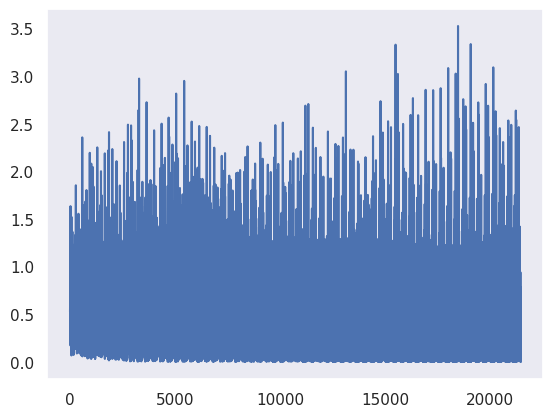

In [32]:
plt.plot(train_losses)

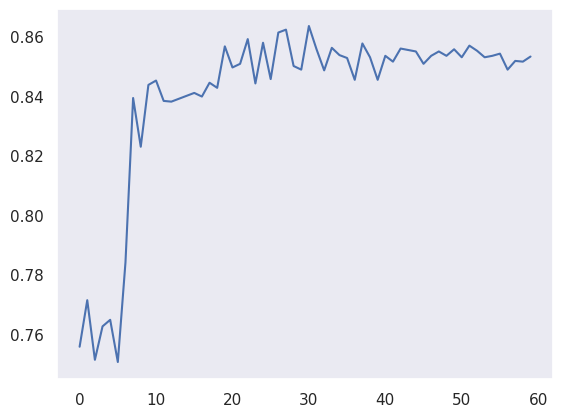

In [33]:
plt.plot(test_accuracy)

In [34]:
metrics2, confusion_matrix2 = report_metrics(model)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 3493/4064 (0.8595)
{'acc_detail': tensor([0.6863, 0.9135], device='cuda:0'),
 'acc_unweighted': tensor(0.7999, device='cuda:0'),
 'acc_weighted': tensor(0.8595, device='cuda:0'),
 'f1s': tensor(0.8037, device='cuda:0'),
 'f1s_detail': tensor([0.6990, 0.9084], device='cuda:0'),
 'precision_detail': tensor([0.7121, 0.9033], device='cuda:0'),
 'recall_detail': tensor([0.6863, 0.9135], device='cuda:0'),
 'rocauc': tensor([0.9030, 0.9030], device='cuda:0'),
 'uar': tensor(0.7999, device='cuda:0'),
 'wap': tensor(0.8579, device='cuda:0')}


tensor([[ 663,  303],
        [ 268, 2830]], device='cuda:0')

In [35]:
model_path = '../physio16k_fold4_m12_60epochs.pt' 
torch.save(model.state_dict(), model_path)

In [36]:
layer = model.fe_blocks.blocks[0].block.layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0075],
        [0.0162],
        [0.0264],
        [0.0384],
        [0.0524],
        [0.0688],
        [0.0880],
        [0.1105],
        [0.1368],
        [0.1676],
        [0.2036],
        [0.2458],
        [0.2952],
        [0.3531],
        [0.4208],
        [0.0000],
        [0.0111],
        [0.0235],
        [0.0375],
        [0.0534],
        [0.0712],
        [0.0912],
        [0.1138],
        [0.1392],
        [0.1679],
        [0.2002],
        [0.2365],
        [0.2775],
        [0.3236],
        [0.3756],
        [0.4341],
        [0.0000],
        [0.0154],
        [0.0322],
        [0.0504],
        [0.0702],
        [0.0918],
        [0.1153],
        [0.1410],
        [0.1687],
        [0.1989],
        [0.2319],
        [0.2677],
        [0.3067],
        [0.3491],
        [0.3952],
        [0.4454],
        [0.0000],
        [0.0200],
        [0.0411],
        [0.0634],
        [0.0869],
       

In [37]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [ 2.0642e-16],
        [ 5.1730e-16],
        [ 2.7274e-16],
        [ 4.3672e-17],
        [ 1.2330e-15],
        [-1.5527e-13],
        [-9.7736e-14],
        [-4.8718e-15],
        [ 3.4305e-15],
        [ 7.6991e-15],
        [ 1.9965e-14],
        [ 1.8253e-15],
        [ 1.3292e-14],
        [-2.4174e-13],
        [-7.6116e-15],
        [ 0.0000e+00],
        [ 1.8052e-14],
        [ 4.0514e-14],
        [ 1.0738e-15],
        [-6.5150e-16],
        [-2.1875e-16],
        [ 5.7181e-16],
        [ 1.8546e-16],
        [-6.1917e-15],
        [ 8.1905e-16],
        [ 1.4120e-15],
        [-2.7173e-15],
        [-4.6624e-16],
        [-1.4079e-15],
        [ 5.7288e-15],
        [-8.7536e-16],
        [ 0.0000e+00],
        [-3.9992e-15],
        [-4.0782e-16],
        [-1.3125e-15],
        [-5.6361e-16],
        [ 4.6782e-16],
        [ 3.7767e-13],
        [ 5.5756e-15],
        [-1.2163e-15],
        [-1.0721e-15],
        [-4.9637e-16],
        [ 4

[None, None, None]

In [38]:
named_params = [p for p in layer.named_parameters()]
named_params

[('lowcut_bands',
  Parameter containing:
  tensor([[0.0000],
          [0.0075],
          [0.0162],
          [0.0264],
          [0.0384],
          [0.0524],
          [0.0688],
          [0.0880],
          [0.1105],
          [0.1368],
          [0.1676],
          [0.2036],
          [0.2458],
          [0.2952],
          [0.3531],
          [0.4208],
          [0.0000],
          [0.0111],
          [0.0235],
          [0.0375],
          [0.0534],
          [0.0712],
          [0.0912],
          [0.1138],
          [0.1392],
          [0.1679],
          [0.2002],
          [0.2365],
          [0.2775],
          [0.3236],
          [0.3756],
          [0.4341],
          [0.0000],
          [0.0154],
          [0.0322],
          [0.0504],
          [0.0702],
          [0.0918],
          [0.1153],
          [0.1410],
          [0.1687],
          [0.1989],
          [0.2319],
          [0.2677],
          [0.3067],
          [0.3491],
          [0.3952],
          [0.4454]

(array([ 4., 16., 34.,  6.,  2.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  2.,  1.,  1.,  1.,  2.,  4.,  1.,  6.,  8.,  4.,  6.,  3.,
         5.,  3.,  4.,  4.,  3.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,
         1.]),
 array([-0.15862459, -0.08498772, -0.01135086,  0.062286  ,  0.13592286,
         0.20955974,  0.2831966 ,  0.35683346,  0.43047032,  0.50410718,
         0.57774407,  0.6513809 ,  0.72501779,  0.79865462,  0.87229151,
         0.94592839,  1.01956522,  1.09320211,  1.166839  ,  1.24047577,
         1.31411266,  1.38774955,  1.46138644,  1.53502333,  1.6086601 ,
         1.68229699,  1.75593388,  1.82957077,  1.90320766,  1.97684443,
         2.05048132,  2.12411809,  2.1977551 ,  2.27139187,  2.34502888,
         2.41866565,  2.49230242,  2.56593943,  2.6395762 ,  2.71321321,
         2.78684998]),
 <BarContainer object of 40 artists>)

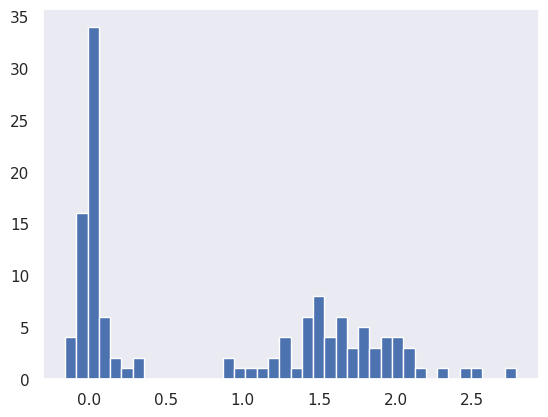

In [39]:
window_params = named_params[2][1].detach().cpu().numpy()
plt.hist(window_params.flatten(), bins=40)

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  3.,  2.,  0.,  2.,
         0.,  2.,  2.,  4.,  9., 31., 45.,  9.,  4.,  2.,  3.,  1.,  1.,
         0.,  0.,  0.,  1.,  1.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,  0.,
         1.]),
 array([-0.08086316, -0.07664615, -0.07242914, -0.06821213, -0.06399512,
        -0.05977811, -0.0555611 , -0.05134409, -0.04712708, -0.04291007,
        -0.03869306, -0.03447604, -0.03025903, -0.02604202, -0.02182501,
        -0.017608  , -0.01339099, -0.00917398, -0.00495697, -0.00073996,
         0.00347706,  0.00769407,  0.01191108,  0.01612809,  0.0203451 ,
         0.02456211,  0.02877912,  0.03299613,  0.03721314,  0.04143015,
         0.04564717,  0.04986418,  0.05408119,  0.0582982 ,  0.06251521,
         0.06673222,  0.07094923,  0.07516624,  0.07938325,  0.08360026,
         0.08781727]),
 <BarContainer object of 40 artists>)

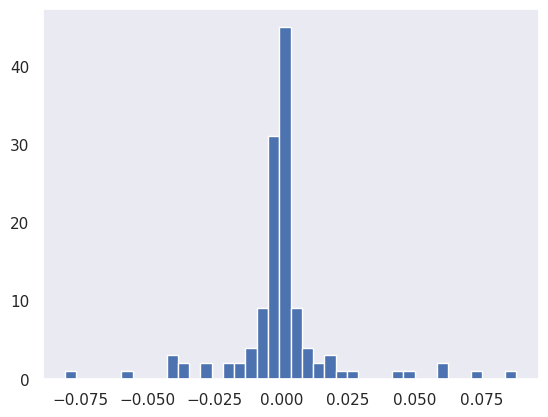

In [40]:
window_params = named_params[2][1].grad.detach().cpu().numpy()
plt.hist(window_params.flatten(), bins=40)

Time domain: Filters' shapes vary by frequency bins


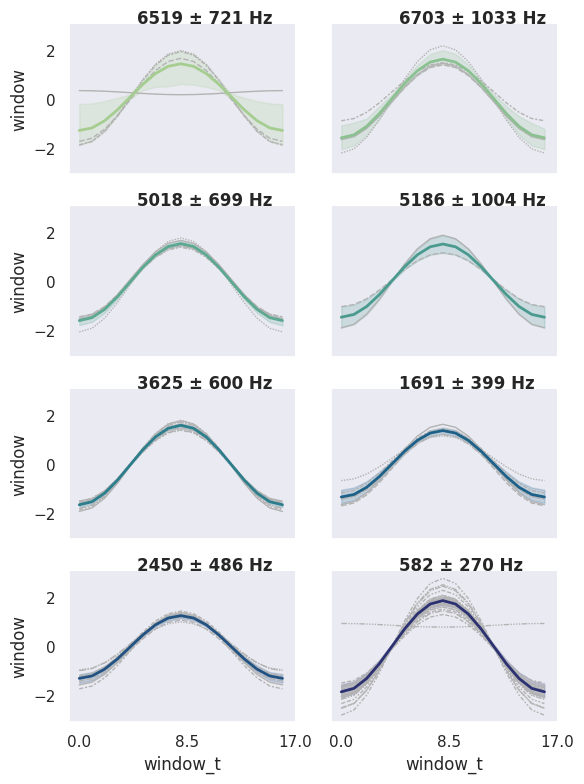

In [41]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


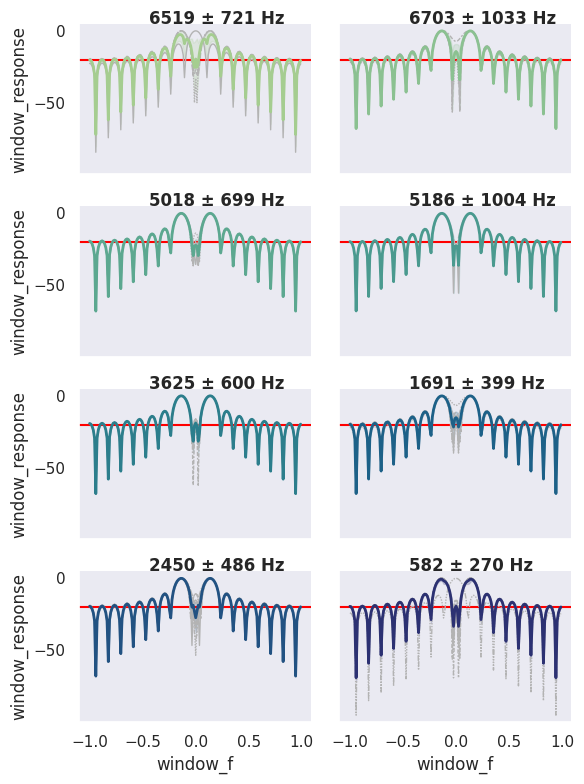

In [42]:
filtviz.visualize_filters(filter_domain='freq')

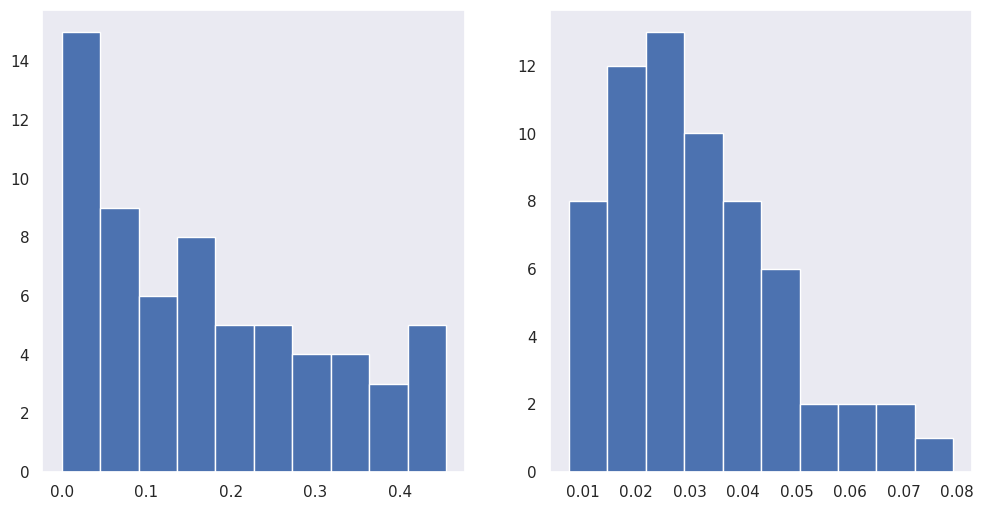

In [43]:
filtviz.visualize_bands()

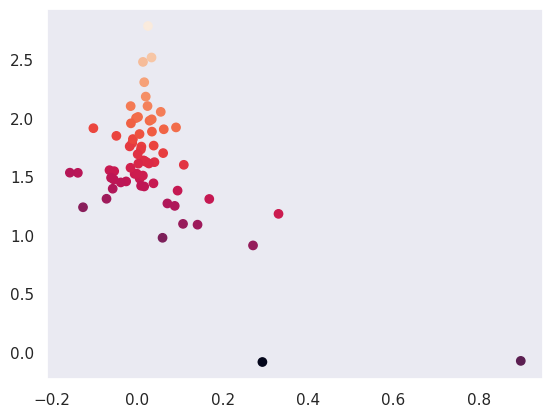

In [44]:
filtviz.visualize_window_params()

In [45]:
layer2 = model.fe_blocks.blocks[1].block.layer
visualize_model.print_parameters(layer2)

('lowcut_bands', Parameter containing:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0075, 0.0075, 0.0075,  ..., 0.0075, 0.0075, 0.0075],
        [0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
        ...,
        [0.3697, 0.3697, 0.3697,  ..., 0.3697, 0.3697, 0.3697],
        [0.4108, 0.4108, 0.4108,  ..., 0.4108, 0.4108, 0.4108],
        [0.4541, 0.4541, 0.4541,  ..., 0.4541, 0.4541, 0.4541]],
       device='cuda:0', requires_grad=True))
('bandwidths', Parameter containing:
tensor([[0.0075, 0.0075, 0.0075,  ..., 0.0075, 0.0075, 0.0075],
        [0.0087, 0.0087, 0.0087,  ..., 0.0087, 0.0087, 0.0087],
        [0.0102, 0.0102, 0.0102,  ..., 0.0102, 0.0102, 0.0102],
        ...,
        [0.0410, 0.0410, 0.0410,  ..., 0.0410, 0.0410, 0.0410],
        [0.0434, 0.0434, 0.0434,  ..., 0.0434, 0.0434, 0.0434],
        [0.0459, 0.0459, 0.0459,  ..., 0.0459, 0.0459, 0.0459]],
       device='cuda:0', requires_grad=True))
('window_params', Parameter containing

In [46]:
named_params2 = [p for p in layer2.named_parameters()]
named_params2

[('lowcut_bands',
  Parameter containing:
  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0075, 0.0075, 0.0075,  ..., 0.0075, 0.0075, 0.0075],
          [0.0162, 0.0162, 0.0162,  ..., 0.0162, 0.0162, 0.0162],
          ...,
          [0.3697, 0.3697, 0.3697,  ..., 0.3697, 0.3697, 0.3697],
          [0.4108, 0.4108, 0.4108,  ..., 0.4108, 0.4108, 0.4108],
          [0.4541, 0.4541, 0.4541,  ..., 0.4541, 0.4541, 0.4541]],
         device='cuda:0', requires_grad=True)),
 ('bandwidths',
  Parameter containing:
  tensor([[0.0075, 0.0075, 0.0075,  ..., 0.0075, 0.0075, 0.0075],
          [0.0087, 0.0087, 0.0087,  ..., 0.0087, 0.0087, 0.0087],
          [0.0102, 0.0102, 0.0102,  ..., 0.0102, 0.0102, 0.0102],
          ...,
          [0.0410, 0.0410, 0.0410,  ..., 0.0410, 0.0410, 0.0410],
          [0.0434, 0.0434, 0.0434,  ..., 0.0434, 0.0434, 0.0434],
          [0.0459, 0.0459, 0.0459,  ..., 0.0459, 0.0459, 0.0459]],
         device='cuda:0', requires_grad=True))

(array([ 4., 16., 34.,  6.,  2.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  2.,  1.,  1.,  1.,  2.,  4.,  1.,  6.,  8.,  4.,  6.,  3.,
         5.,  3.,  4.,  4.,  3.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,
         1.]),
 array([-0.15862459, -0.08498772, -0.01135086,  0.062286  ,  0.13592286,
         0.20955974,  0.2831966 ,  0.35683346,  0.43047032,  0.50410718,
         0.57774407,  0.6513809 ,  0.72501779,  0.79865462,  0.87229151,
         0.94592839,  1.01956522,  1.09320211,  1.166839  ,  1.24047577,
         1.31411266,  1.38774955,  1.46138644,  1.53502333,  1.6086601 ,
         1.68229699,  1.75593388,  1.82957077,  1.90320766,  1.97684443,
         2.05048132,  2.12411809,  2.1977551 ,  2.27139187,  2.34502888,
         2.41866565,  2.49230242,  2.56593943,  2.6395762 ,  2.71321321,
         2.78684998]),
 <BarContainer object of 40 artists>)

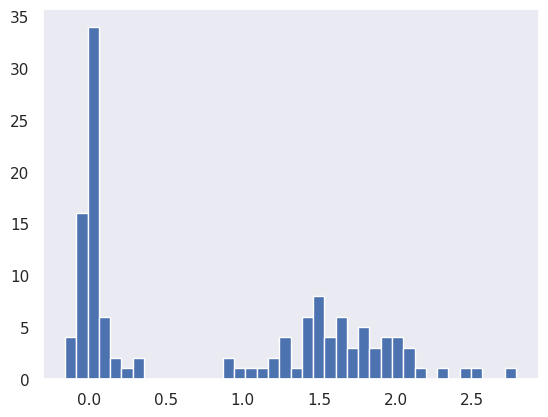

In [47]:
window_params2 = named_params[2][1].detach().cpu().numpy()
plt.hist(window_params2.flatten(), bins=40)

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  3.,  2.,  0.,  2.,
         0.,  2.,  2.,  4.,  9., 31., 45.,  9.,  4.,  2.,  3.,  1.,  1.,
         0.,  0.,  0.,  1.,  1.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,  0.,
         1.]),
 array([-0.08086316, -0.07664615, -0.07242914, -0.06821213, -0.06399512,
        -0.05977811, -0.0555611 , -0.05134409, -0.04712708, -0.04291007,
        -0.03869306, -0.03447604, -0.03025903, -0.02604202, -0.02182501,
        -0.017608  , -0.01339099, -0.00917398, -0.00495697, -0.00073996,
         0.00347706,  0.00769407,  0.01191108,  0.01612809,  0.0203451 ,
         0.02456211,  0.02877912,  0.03299613,  0.03721314,  0.04143015,
         0.04564717,  0.04986418,  0.05408119,  0.0582982 ,  0.06251521,
         0.06673222,  0.07094923,  0.07516624,  0.07938325,  0.08360026,
         0.08781727]),
 <BarContainer object of 40 artists>)

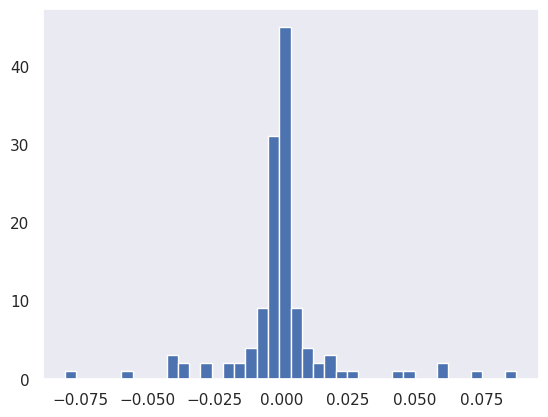

In [48]:
window_params2 = named_params[2][1].grad.detach().cpu().numpy()
plt.hist(window_params2.flatten(), bins=40)

downsample_factor: 8 => new_sample_rate: 2000
Time domain: Filters' shapes vary by frequency bins


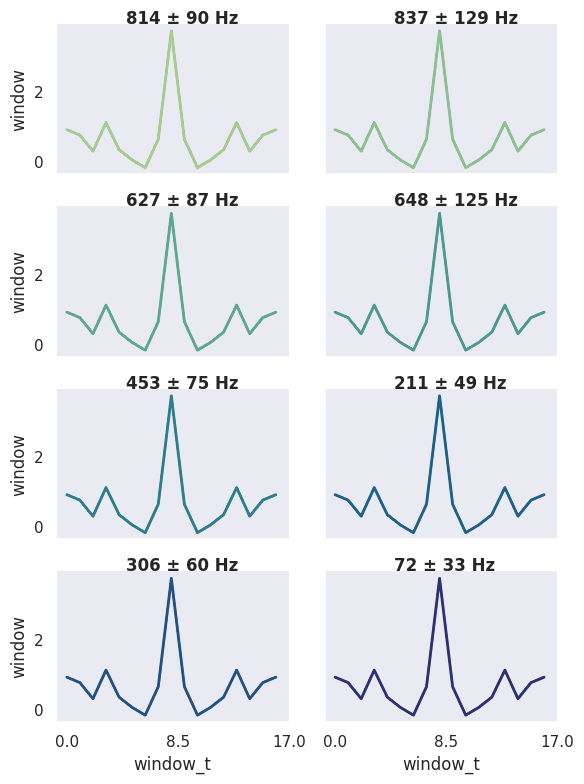

In [49]:
downsample_factor = model.fe_blocks.blocks[0].stride
new_sample_rate = sr // downsample_factor
print(f'downsample_factor: {downsample_factor} => new_sample_rate: {new_sample_rate}')

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = layer2.window_params, 
    window_length = 64,
    sample_rate = new_sample_rate
)
filtviz2.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


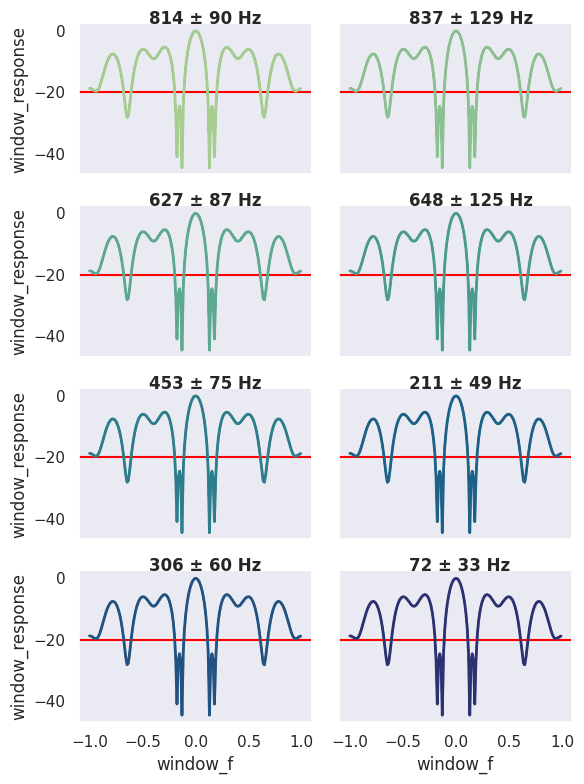

In [50]:
filtviz2.visualize_filters(filter_domain='freq')

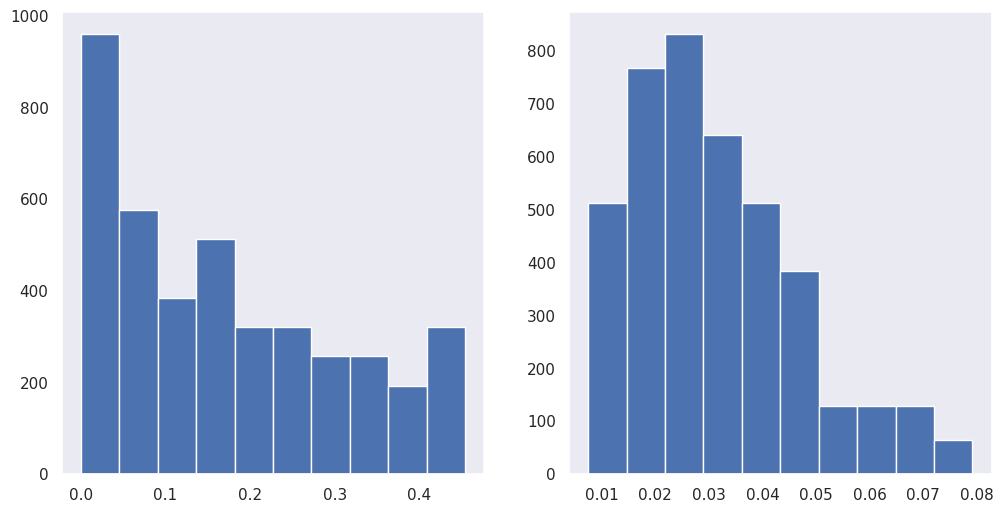

In [51]:
filtviz2.visualize_bands()

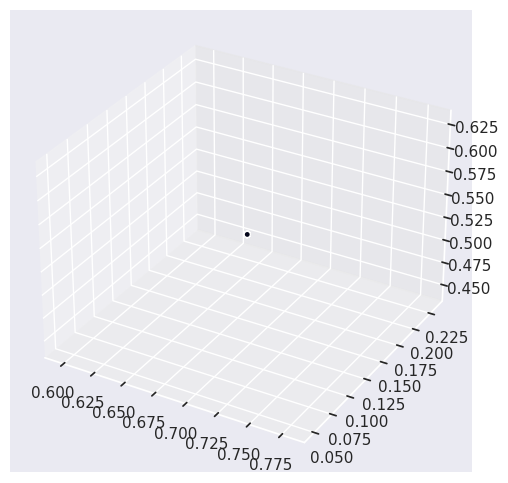

In [52]:
filtviz2.visualize_window_params()

In [53]:
# del model
# gc.collect()

338506